In [21]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns 
import statsmodels.api as sm
from tqdm import tqdm, tnrange, tqdm_notebook


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


		 	 	 		
			
				
	
# Derivation of the Spread Dynamics

Imagine an asset $A$ that can be replicated, imperfectly, by some carefully chosen group of other assets. Let us call this group the synthetic hedge and denote it by $H$. Since the asset and its synthetic hedge share exposure to underlying processes, we can potentially eliminate a large part of the $A$'s variance by subtracting off the synthetic hedge. We are left with exposure to the spread, i.e., $$Y_t=\log \left(\frac{A_t}{A_0}\right)-\log \left(\frac{H_t}{H_0}\right).$$ Now, analysis can be based on this spread. As an example, we might hypothesize that $Y_t$ is mean reverting. In order to optimally forecast $Y_t$ we have to think about how to model it. Modeling by a simple mean reverting process implies that $A$ and $H$ won't diverge too far from one another. Data of real world spreads contradicts this assumption. In fact, spreads tend to look close to geometric Brownian motion. If this were actually the case, there is no hope for forecasting future returns. However, it is possible that the spread has elements of both. 

## Hypothetical Dynamics (1)

Let us define a stochastic process that is common to both $H$ and $A$ $$C_t = C_{t-1} + \epsilon_t,$$ where $\epsilon_t \sim \mathcal{N}\left(\mu, \sigma^{2}_1\right)$. In words, $C_t$ is a geometric random walk. On top of that there is another random walk, independent of $C_t$, that is specific to $A$. Let us denote this process by $S_t$ and define it by $$S_t = S_{t-1} + \omega_t,$$ where $\omega_t \sim \mathcal{N}\left(0, \sigma^{2}_\omega\right)$. This process can be thought of as returns attributable to asset specific factors such as innovation, leadership, or lawsuits for a stock as an example. Next we define a mean reverting process, $$ R_t = \phi R_{t-1} + u_t,$$ where  $u_t \sim \mathcal{N}\left(0, \sigma^{2}_2\right).$ $R_t$ is an autoregressive process of order 1. This process can be thought of as temporary dislocations due to noise traders, order imbalances or a failure of timely information propagation. 

Let's imagine that $A_t$ develops as $$A_t = \exp\big(C_t + S_t + R_t\big).$$ 

$H_t$ is a function of the common process only and hence modeled by $$H_t = \exp\big(C_t\big)$$ 


Suppose that $\sigma^{2}_1 >> \sigma^{2}_2$. In that case, there is too little signal in $A_t$ to observe it directly. Through hedging we can create exposure to the spread, though.
To extract the spread we buy $A_t$ and short $H_t$. The log-return of this configuration from now $(t=0)$ to time $t$ is $$\log \frac{A_t}{A_0} - \log \frac{H_t}{H_0} =  (C_t + S_t + R_t) - (C_0 + S_0 + R_0) - (C_t-C_0) = R_t + S_t - R_0 - S_0.$$
I.e. the spread is a random walk around which an AR(1) process fluctuates. Since the random walk dominates asymptotically, this process is nonstationary. In other words, spread is  modeled as a random walk observed with autocorrelated noise. These dynamics can be described by an ARIMA(1, 1, 1) model, which can be estimated via maximum likelihood estimation. 

## Hypothetical Dynamics (2) 

One may also argue that the idiosyncratic process $S_t$ is an almost-nonstationary autoregressive process instead of a random walk. This process is modeled by local-to-unity autoregressive root, i.e., $\phi$ is not 1 but close to it. Granger and & Morris (1976) show that AR($p$) $+$ AR($q$) $=$ ARMA($p+q$, $max(p,q)$). Hence, the spread in our example would be modeled by an ARIMA(2, 0, 1).

## Hypothetical Dynamics (3) 

Furthermore, $H_t$ may also be a function of a specific random walk, which is defined by $$S_t^H = S_{t-1}^H + \omega_t^H,$$ where $\omega_t^H \sim \mathcal{N}\left(0, \sigma^{2}_{\omega^H}\right)$ and $\omega_t^H$ is independent of $\omega_t$. In addition $H_t$ may have a mean-reverting element, $R_t^H$,  independent of all other processes considered so far. Then the spread is a random walk observed with ARMA(2,1) noise. Since any random walk with ARMA(p,q) noise is an ARIMA process, this spread can be modeled by an ARIMA model. 







# Simulation

In [2]:
def generate_garch_11_ts(n, sigma_sq_0, mu, alpha, beta, omega):
    """ generate GARCH log returns """
    nu = np.random.normal(0,1,n)
    r = np.zeros(n)
    epsilon = np.zeros(n)
    sigma_sq = np.zeros(n)
    sigma_sq[0] = sigma_sq_0
    
    if min(alpha,beta)<0:
        raise ValueError('alpha, beta need to be non-negative')
    if omega <=0:
        raise ValueError('omega needs to be positive')
        
    if alpha+beta>=1:
        print('alpha+beta>=1, variance not defined --> time series will not be weakly stationary')
        
    for i in range(n):
        
        if i >0:
            sigma_sq[i] = omega + alpha * epsilon[i-1]**2 + beta * sigma_sq[i-1]
            
        epsilon[i] = (sigma_sq[i]**0.5) * nu[i]

        r[i] = mu + epsilon[i]
    return r 

In [3]:
def ornstein_uhlenbeck(theta, sigma, size, mu=0, x0=0):
    x = np.zeros(size)
    x[0] = x0
    for i in range(1,size):
        dx = theta*(mu-x[i-1]) + sigma*np.random.normal(0,1)
        x[i] = dx + x[i-1]
    return x

## Simulating an Asset and its Synthetic Hedge According to Hypothetical Dynamics (1) 

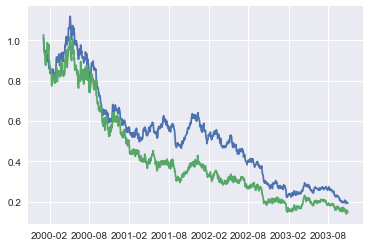

In [17]:
epsilon = np.random.normal(0.0001,0.02,1000)

# Gaussian specific innovations
omega = np.random.normal(0, 0.01, epsilon.shape[0]) 

# Student t specific innovations
# omega =  0.01*np.random.standard_t(2, epsilon.shape[0]) 

# GARCH specific innovations
# omega = generate_garch_11_ts(epsilon.shape[0], sigma_sq_0=0, mu=0, alpha=0.1, beta=0.89, omega=0.0001)

H = np.exp(np.cumsum(epsilon))
R = ornstein_uhlenbeck(0.5, 0.02, epsilon.shape[0]+1, mu=0, x0=0)
S = omega.cumsum()


# all equivalent calculations
# A = np.exp(np.cumsum(epsilon + omega + np.diff(R)))
# A = np.exp(np.cumsum(epsilon) + S + R[1:])
# A = np.exp(np.log(H) + S + R[1:])
A = H*np.exp(S + R[1:])


prices = pd.DataFrame(data={'H':H, 'A':A})
prices.index = pd.date_range(start='1/1/2000', periods=len(prices), freq='B')

plt.plot(prices)
plt.show()

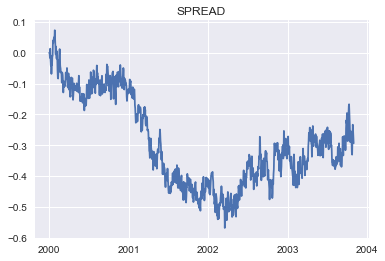

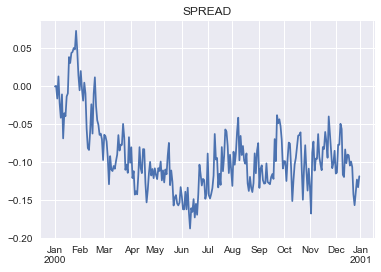

(-2.0511441961188766,
 0.26460776664524477,
 5,
 994,
 {'1%': -3.43694584277544,
  '5%': -2.8644520725172873,
  '10%': -2.5683205291305176},
 -4512.420259654631)

In [18]:
Y = np.log(prices.A) - np.log(prices.A.iloc[0]) - (np.log(prices.H) - np.log(prices.H.iloc[0]))

Y.plot()
plt.title('SPREAD')
plt.show()

Y['2000'].plot()
plt.title('SPREAD')
plt.show()

adfuller(Y)

## Simulating an Asset and its Synthetic Hedge According to Hypothetical Dynamics (3)

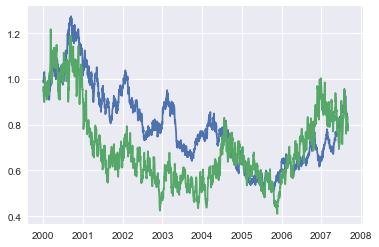

In [19]:
n_obs = 2000

# Common Gaussain returns
epsilon = np.random.normal(0.0,0.006, n_obs)

# Gaussian specific innovations
omega = np.random.normal(0, 0.01, epsilon.shape[0]) 
omega_H = np.random.normal(0, 0.01, epsilon.shape[0]) 
S = omega.cumsum()
S_H = omega_H.cumsum()

# Mean reverting process
R = ornstein_uhlenbeck(0.1, 0.03, epsilon.shape[0]+1, mu=0, x0=0)
R_H = ornstein_uhlenbeck(0.3, 0.01, epsilon.shape[0]+1, mu=0, x0=0)

H = np.exp(np.cumsum(epsilon + omega_H + np.diff(R_H)))
A = np.exp(np.cumsum(epsilon + omega + np.diff(R)))

prices = pd.DataFrame(data={'H':H, 'A':A})
prices.index = pd.date_range(start='1/1/2000', periods=len(prices), freq='B')

plt.plot(prices)
plt.show()


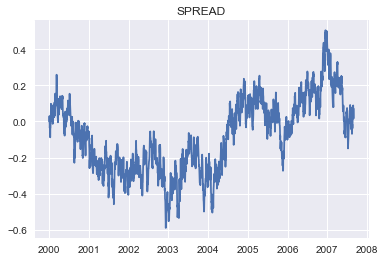

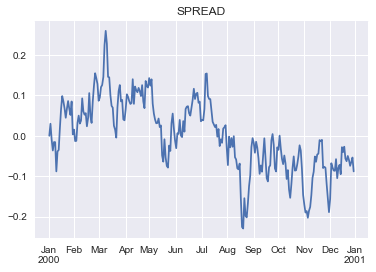

(-2.192220431265667,
 0.2090810982435356,
 16,
 1983,
 {'1%': -3.4336519592295947,
  '5%': -2.862998620943585,
  '10%': -2.567546508593341},
 -7613.8196161961005)

In [20]:
Y = np.log(prices.A) - np.log(prices.A.iloc[0]) - (np.log(prices.H) - np.log(prices.H.iloc[0]))

Y.plot()
plt.title('SPREAD')
plt.show()

Y['2000'].plot()
plt.title('SPREAD')
plt.show()

adfuller(Y)

# SARIMAX Model Selection

(1, 1, 1)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1931.066
Date:                Sun, 01 Dec 2019   AIC                          -3856.132
Time:                        22:32:27   BIC                          -3841.411
Sample:                    01-03-2000   HQIC                         -3850.537
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9256      0.034     27.339      0.000       0.859       0.992
ma.L1         -0.9618      0.025    -38.187      0.000      -1.011      -0.912
sigma2         0.0012   5.48e-05     22.35

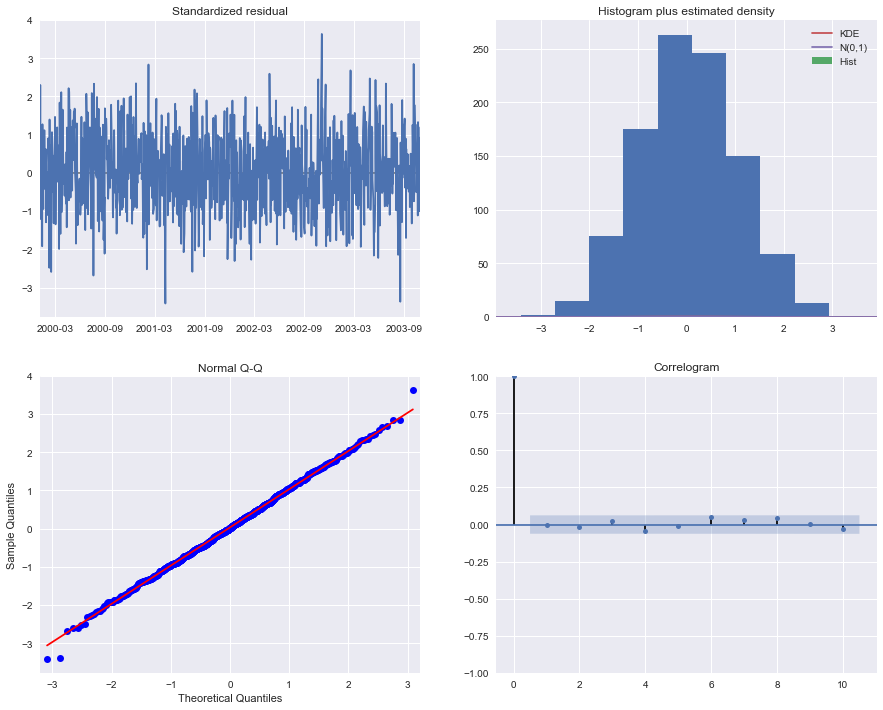

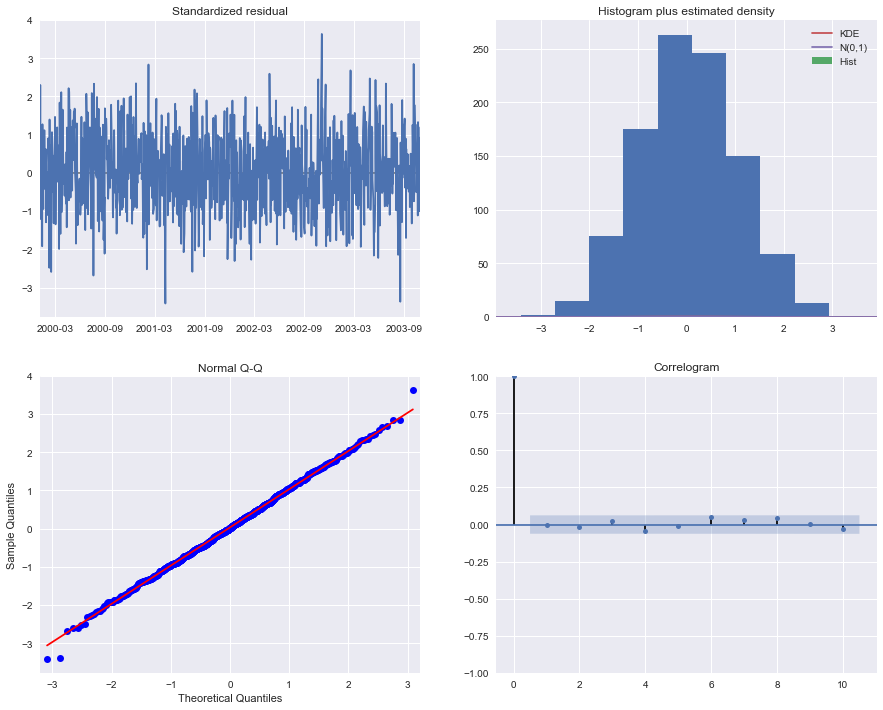

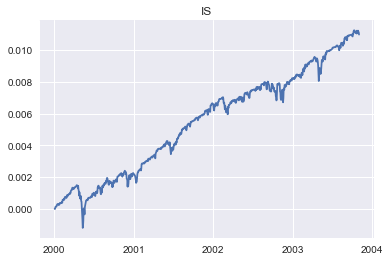

IR 1.4942128263094947


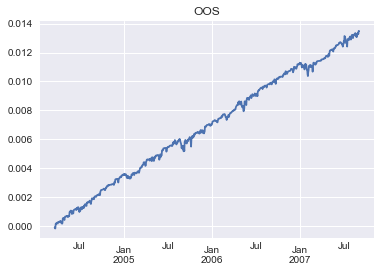

IR 2.4471812792725


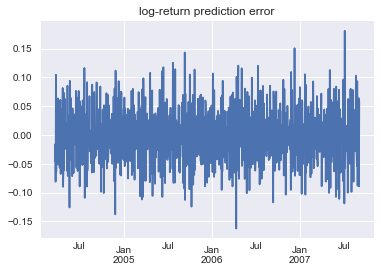

(1, 1, 2)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1931.075
Date:                Sun, 01 Dec 2019   AIC                          -3854.151
Time:                        22:32:29   BIC                          -3834.524
Sample:                    01-03-2000   HQIC                         -3846.691
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9272      0.037     25.194      0.000       0.855       0.999
ma.L1         -0.9674      0.050    -19.167      0.000      -1.066      -0.868
ma.L2          0.0048      0.035      0.13

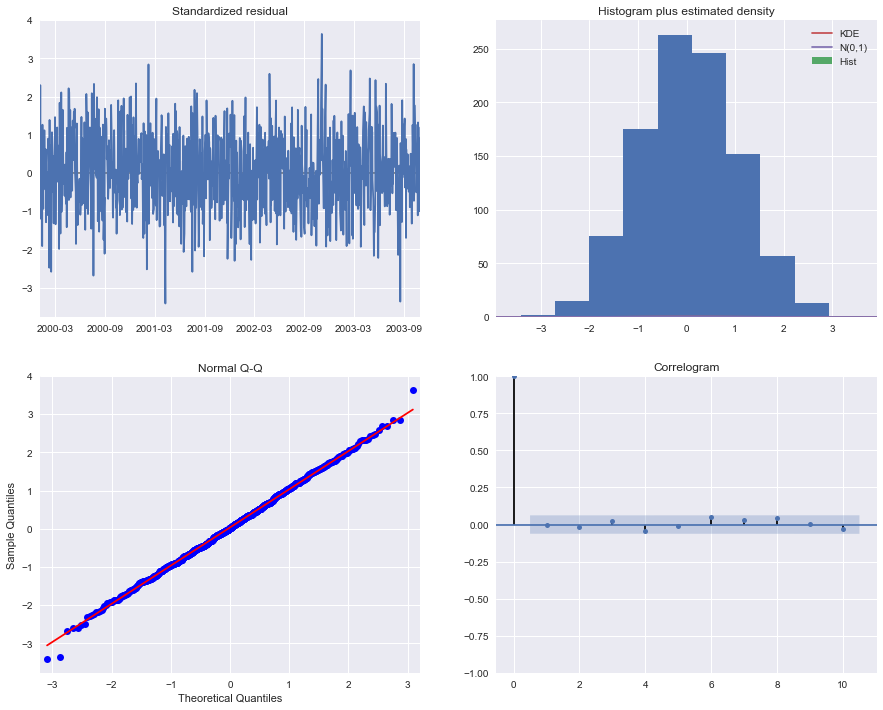

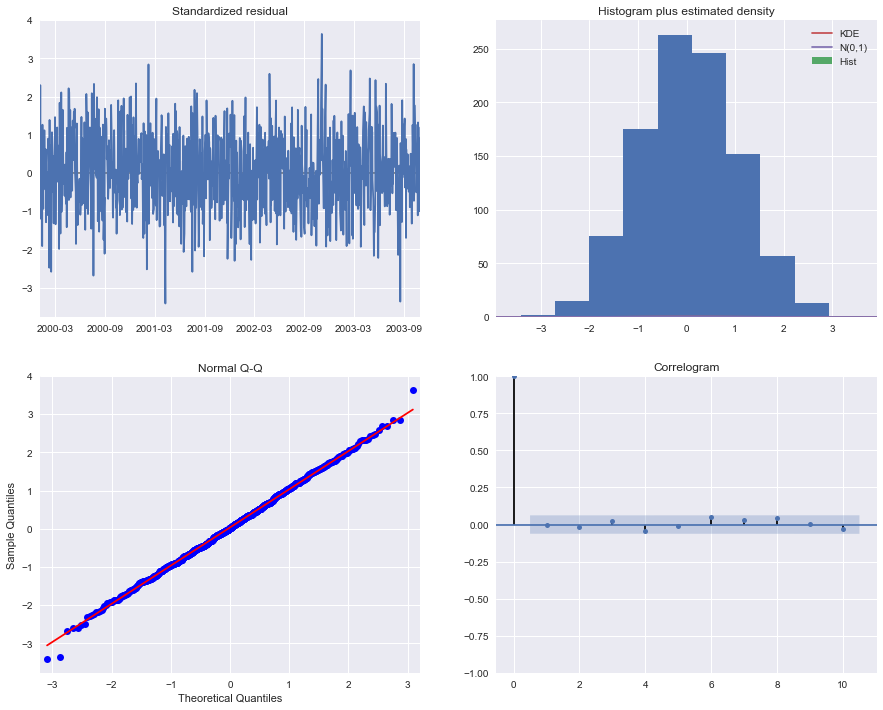

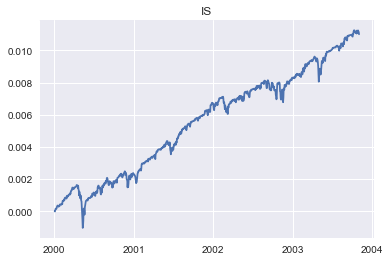

IR 1.4998952570133695


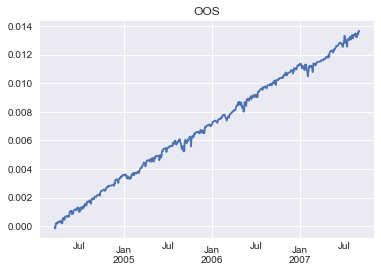

IR 2.468582422019113


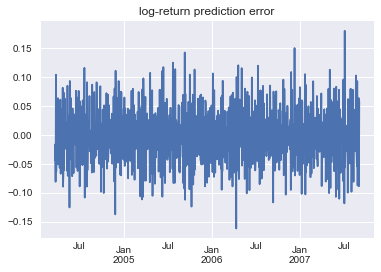

(1, 1, 3)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 3)   Log Likelihood                1928.167
Date:                Sun, 01 Dec 2019   AIC                          -3846.334
Time:                        22:32:31   BIC                          -3821.800
Sample:                    01-03-2000   HQIC                         -3837.009
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2082      1.913      0.109      0.913      -3.542       3.958
ma.L1         -0.2419      1.914     -0.126      0.899      -3.993       3.509
ma.L2         -0.0373      0.073     -0.51

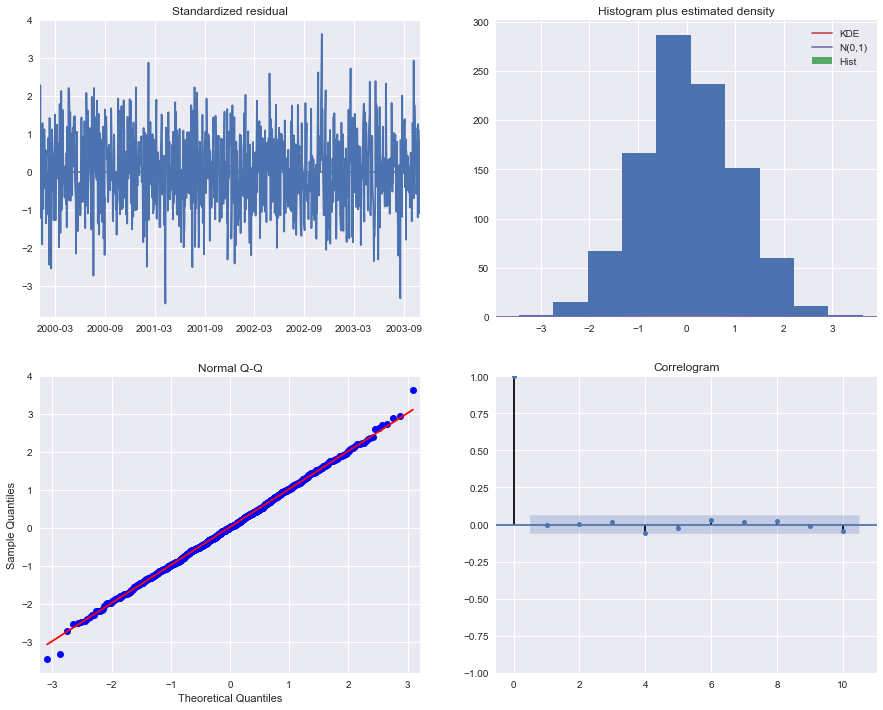

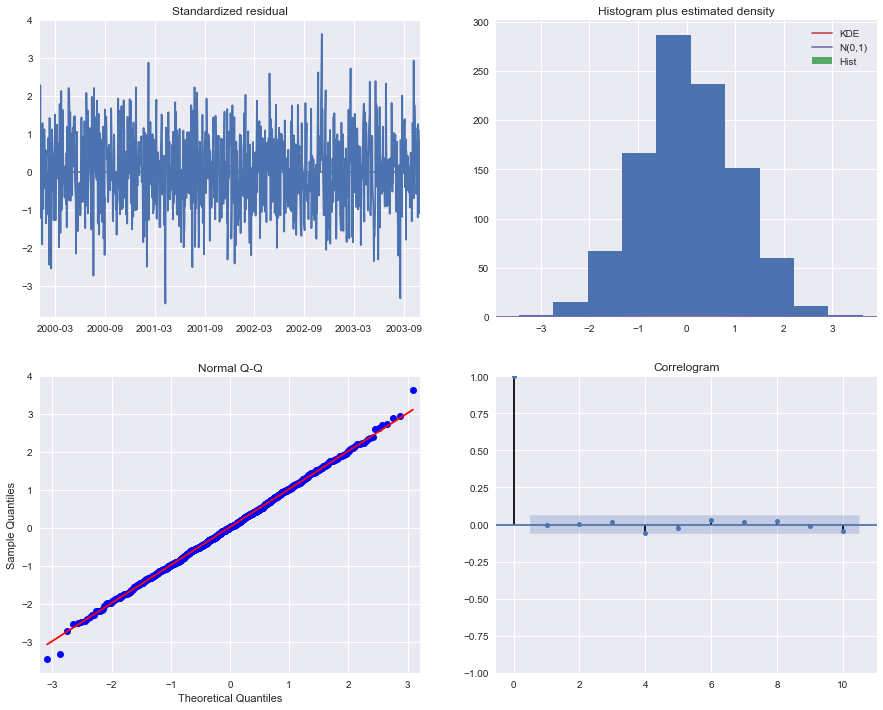

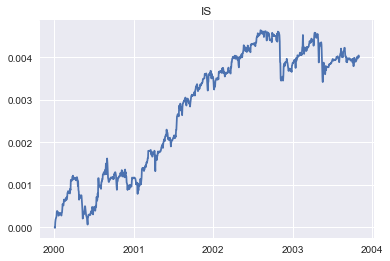

IR 0.8734337078801405


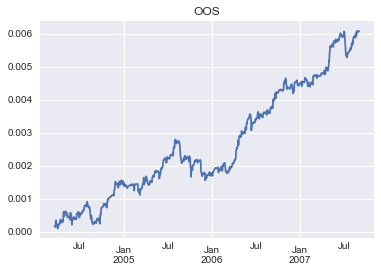

IR 1.640121957010361


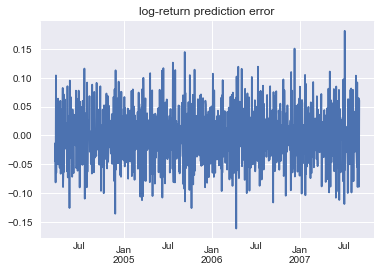

(1, 1, 4)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 4)   Log Likelihood                1930.087
Date:                Sun, 01 Dec 2019   AIC                          -3848.174
Time:                        22:32:33   BIC                          -3818.734
Sample:                    01-03-2000   HQIC                         -3836.984
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2450      0.450      0.544      0.587      -0.638       1.128
ma.L1         -0.2794      0.449     -0.623      0.533      -1.158       0.600
ma.L2         -0.0292      0.035     -0.82

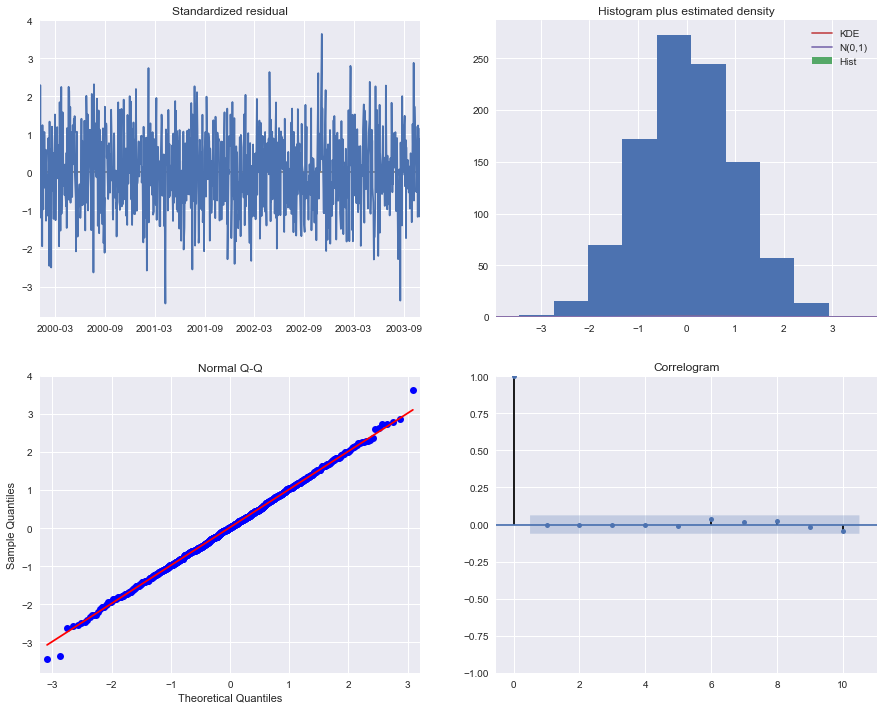

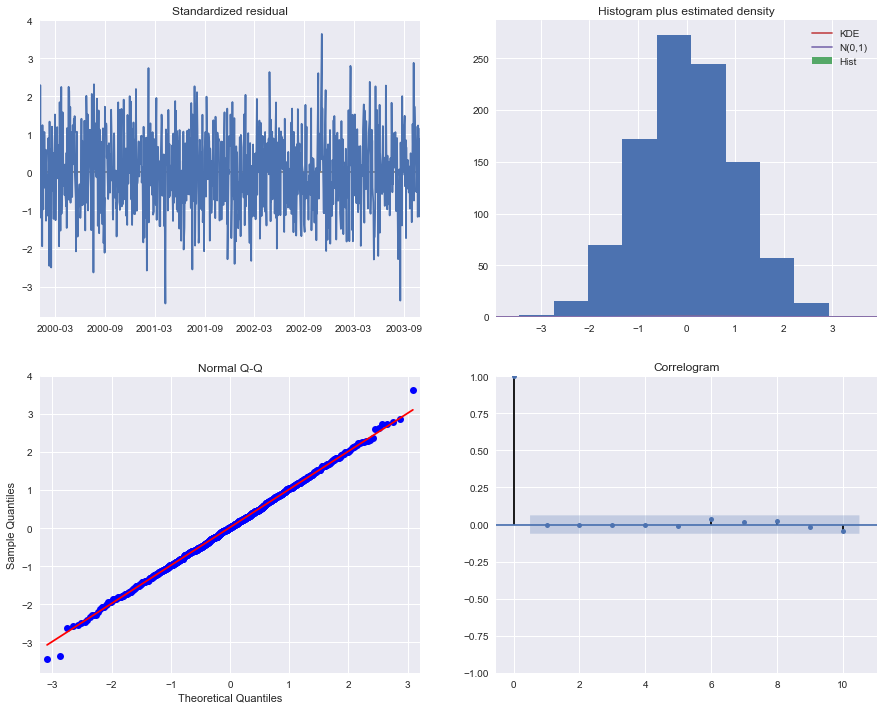

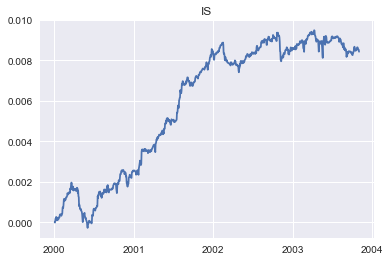

IR 1.2987352611096565


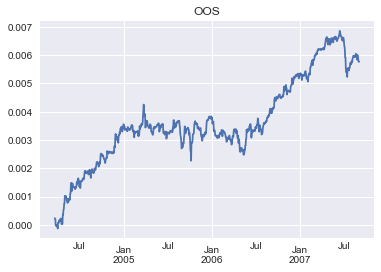

IR 1.0675210426465536


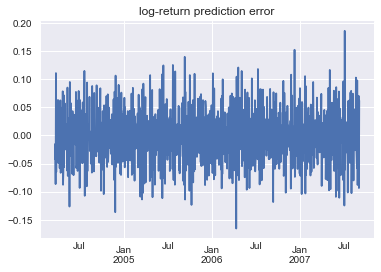

(2, 1, 1)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 1, 1)   Log Likelihood                1927.900
Date:                Sun, 01 Dec 2019   AIC                          -3847.800
Time:                        22:32:36   BIC                          -3828.173
Sample:                    01-03-2000   HQIC                         -3840.340
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0196      0.837     -0.023      0.981      -1.659       1.620
ar.L2         -0.0388      0.042     -0.921      0.357      -0.121       0.044
ma.L1         -0.0121      0.839     -0.01

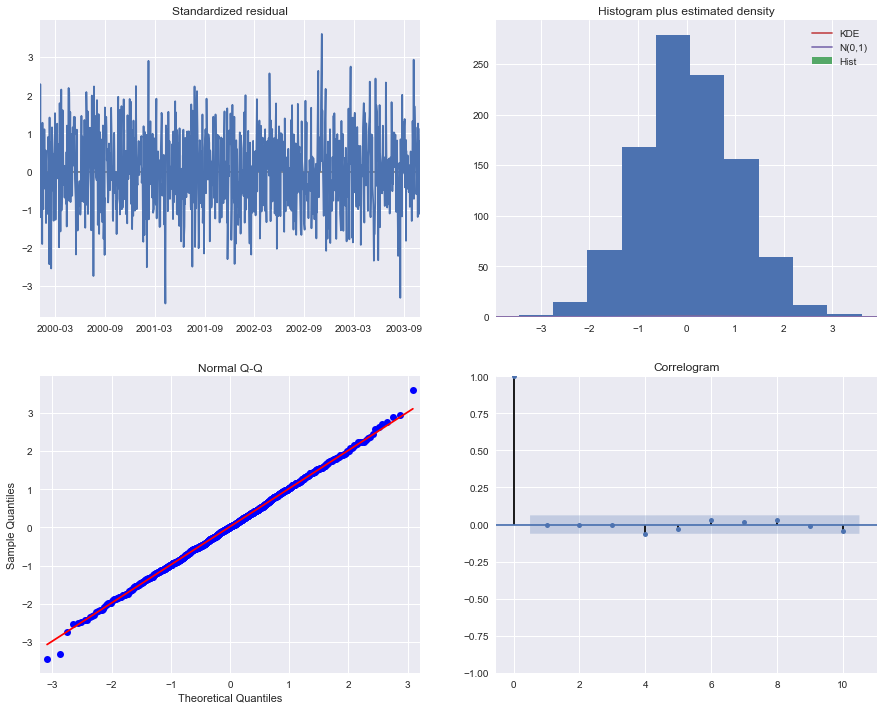

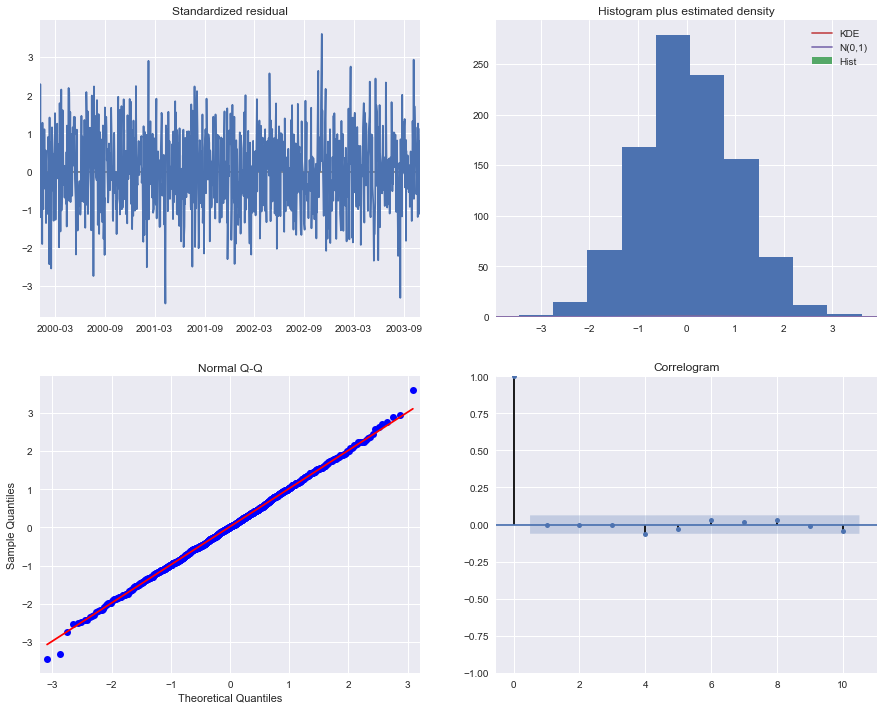

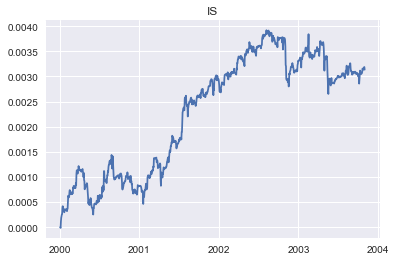

IR 0.7997259916794396


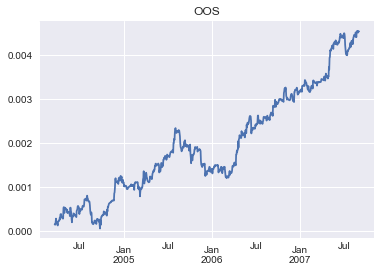

IR 1.3570442574920212


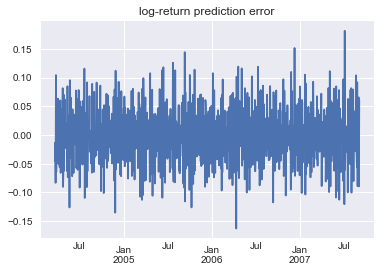

(2, 1, 2)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 1, 2)   Log Likelihood                1931.241
Date:                Sun, 01 Dec 2019   AIC                          -3852.483
Time:                        22:32:38   BIC                          -3827.949
Sample:                    01-03-2000   HQIC                         -3843.158
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1391      0.654      0.213      0.832      -1.143       1.421
ar.L2          0.7245      0.612      1.183      0.237      -0.475       1.924
ma.L1         -0.1646      0.640     -0.25

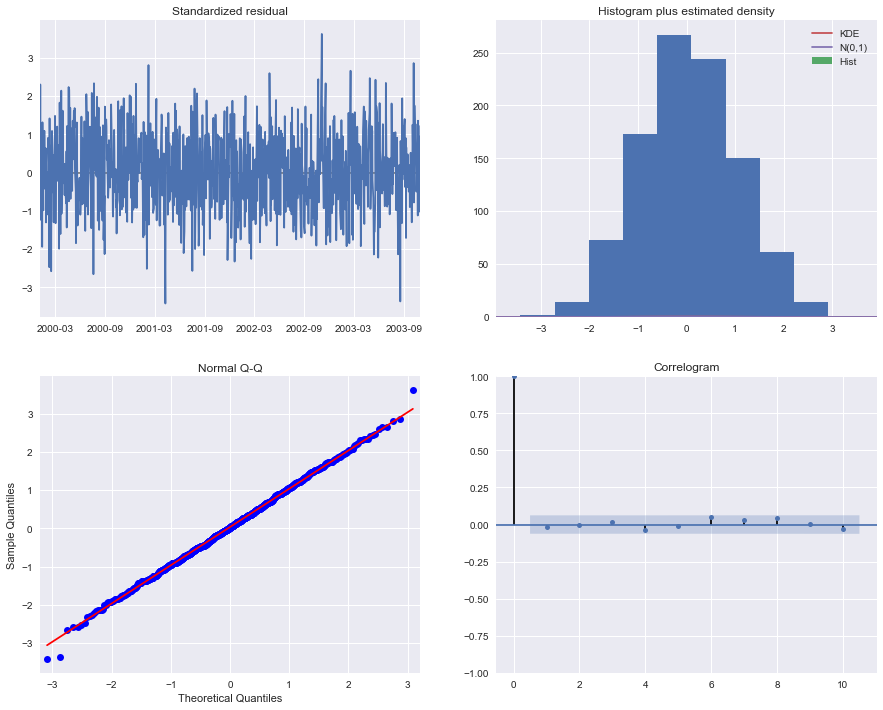

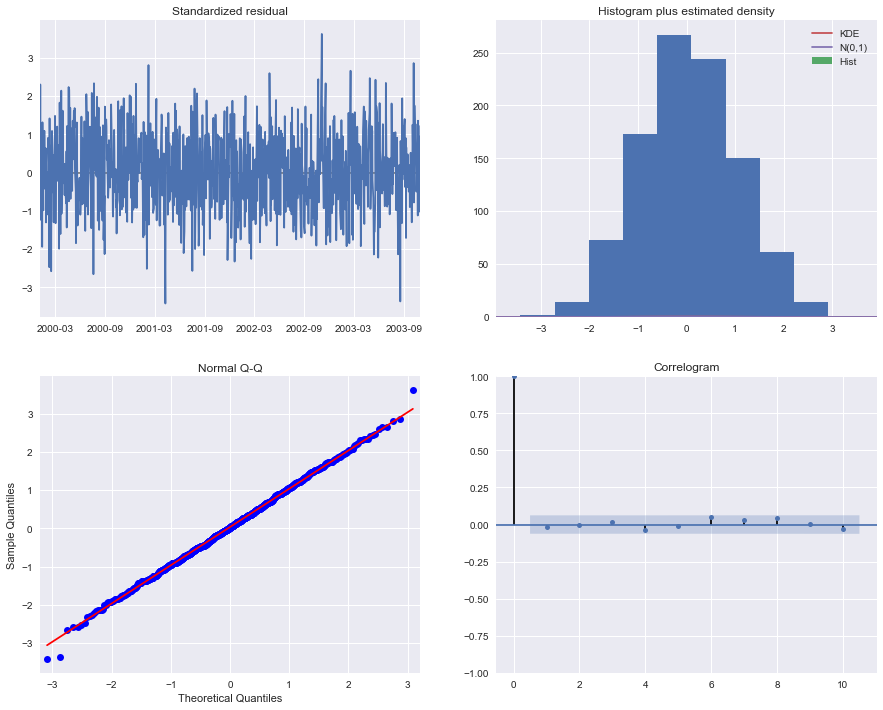

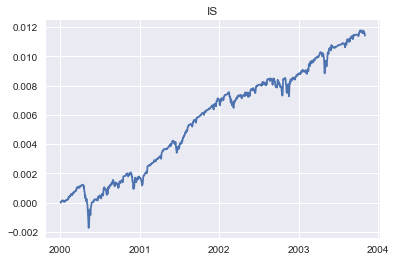

IR 1.51378437130849


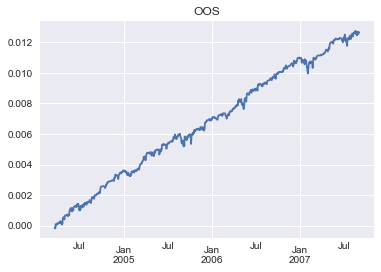

IR 2.2673976883055906


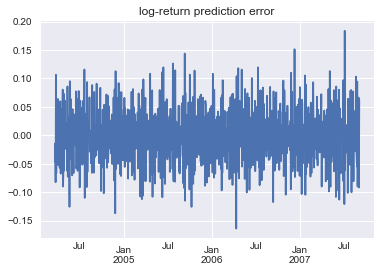

(2, 1, 3)


/Users/jan/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 1, 3)   Log Likelihood                1931.369
Date:                Sun, 01 Dec 2019   AIC                          -3850.739
Time:                        22:32:41   BIC                          -3821.298
Sample:                    01-03-2000   HQIC                         -3839.549
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0767      0.366      0.210      0.834      -0.641       0.795
ar.L2          0.7911      0.327      2.421      0.015       0.151       1.431
ma.L1         -0.1162      0.368     -0.316      0.7

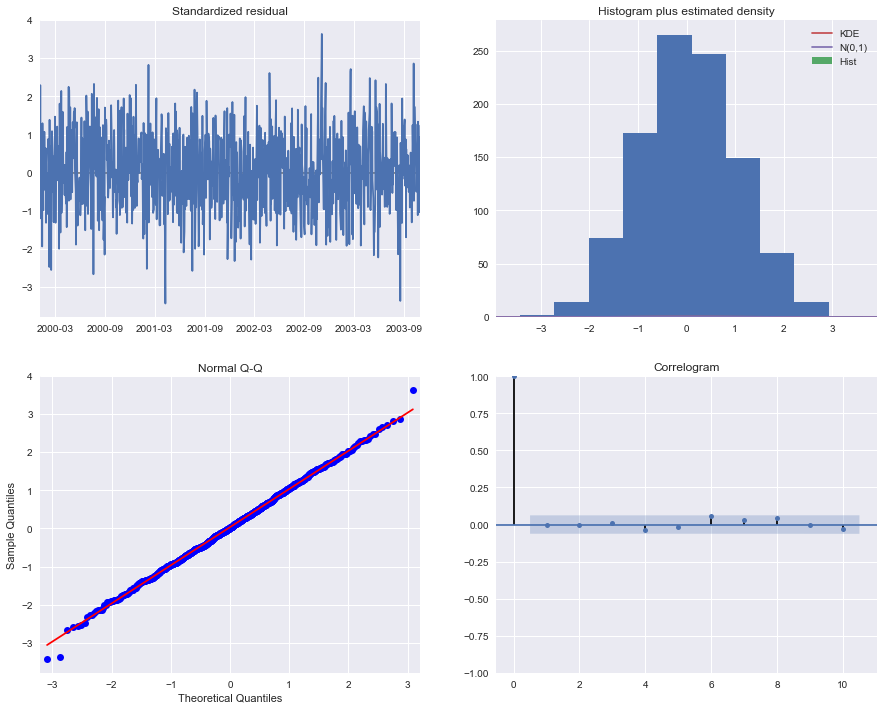

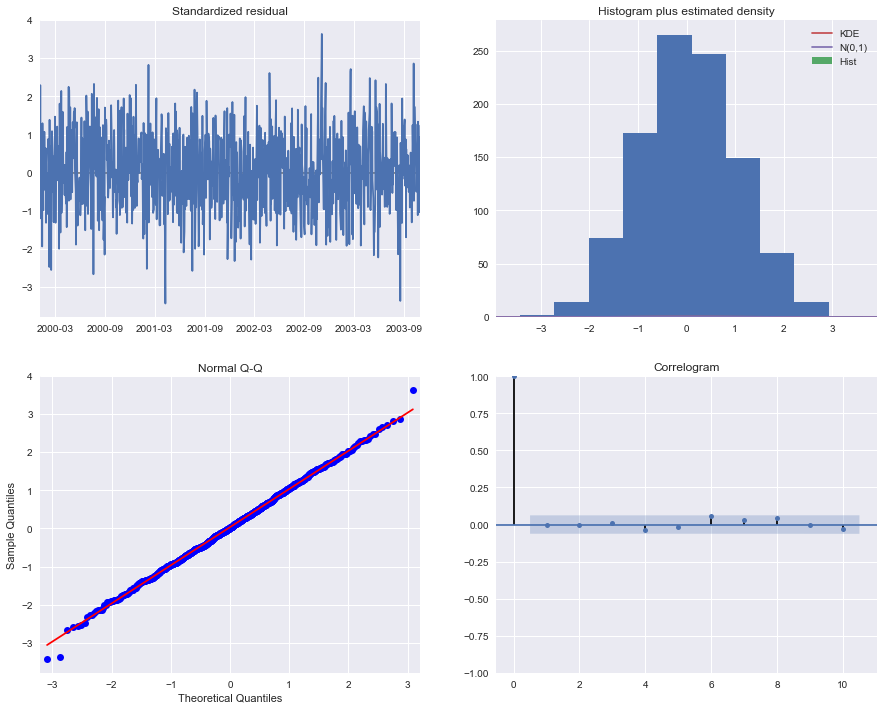

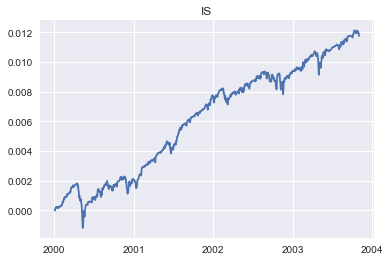

IR 1.550203474343628


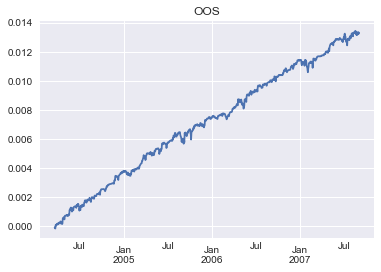

IR 2.324604742804134


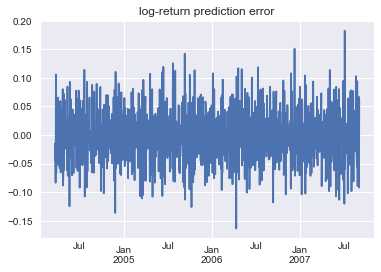

(2, 1, 4)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 1, 4)   Log Likelihood                1930.913
Date:                Sun, 01 Dec 2019   AIC                          -3847.827
Time:                        22:32:43   BIC                          -3813.480
Sample:                    01-03-2000   HQIC                         -3834.772
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3707      0.316      1.172      0.241      -0.249       0.991
ar.L2         -0.4810      0.318     -1.514      0.130      -1.104       0.142
ma.L1         -0.4055      0.314     -1.28

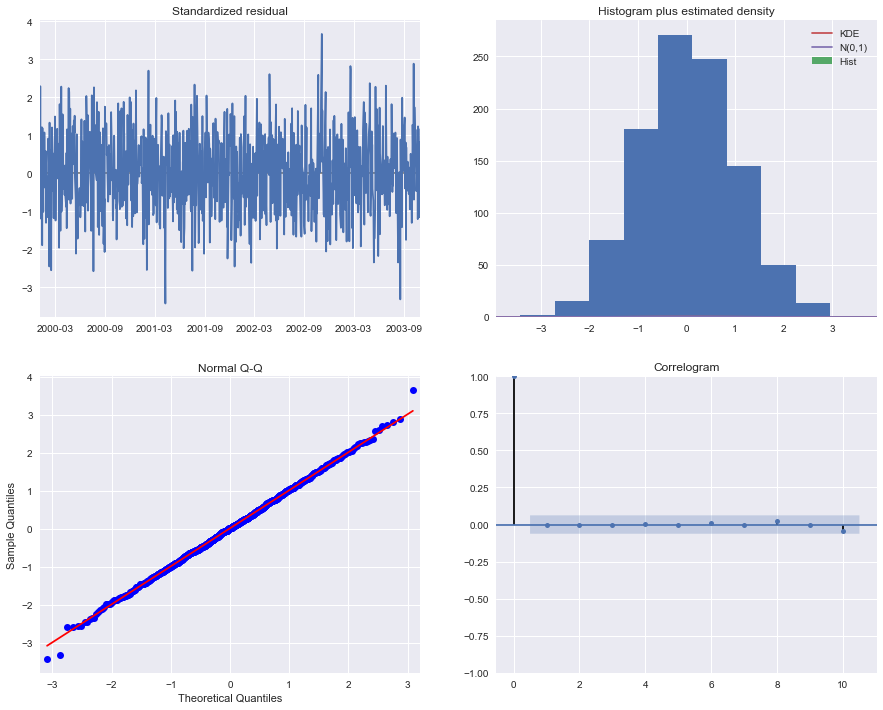

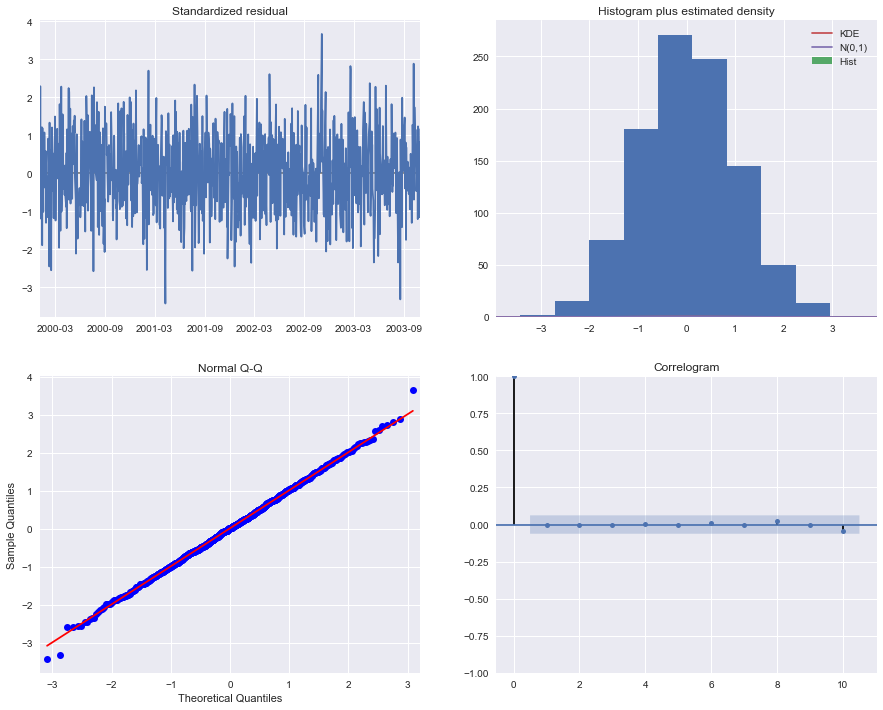

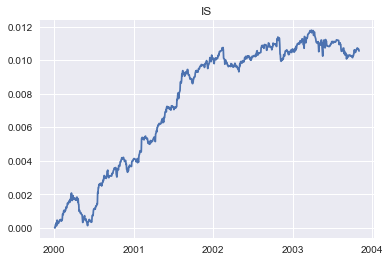

IR 1.4505536560571917


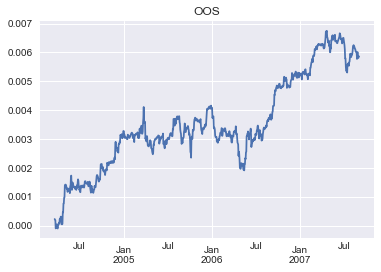

IR 0.9215430975250484


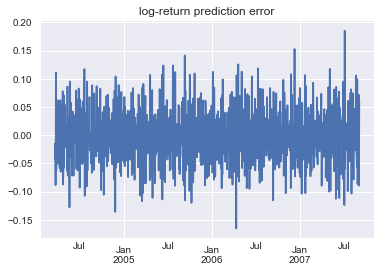

(3, 1, 1)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 1, 1)   Log Likelihood                1927.900
Date:                Sun, 01 Dec 2019   AIC                          -3845.800
Time:                        22:32:45   BIC                          -3821.267
Sample:                    01-03-2000   HQIC                         -3836.475
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0152     67.413     -0.000      1.000    -132.143     132.112
ar.L2         -0.0386      2.134     -0.018      0.986      -4.221       4.144
ar.L3          0.0002      2.638   6.69e-0

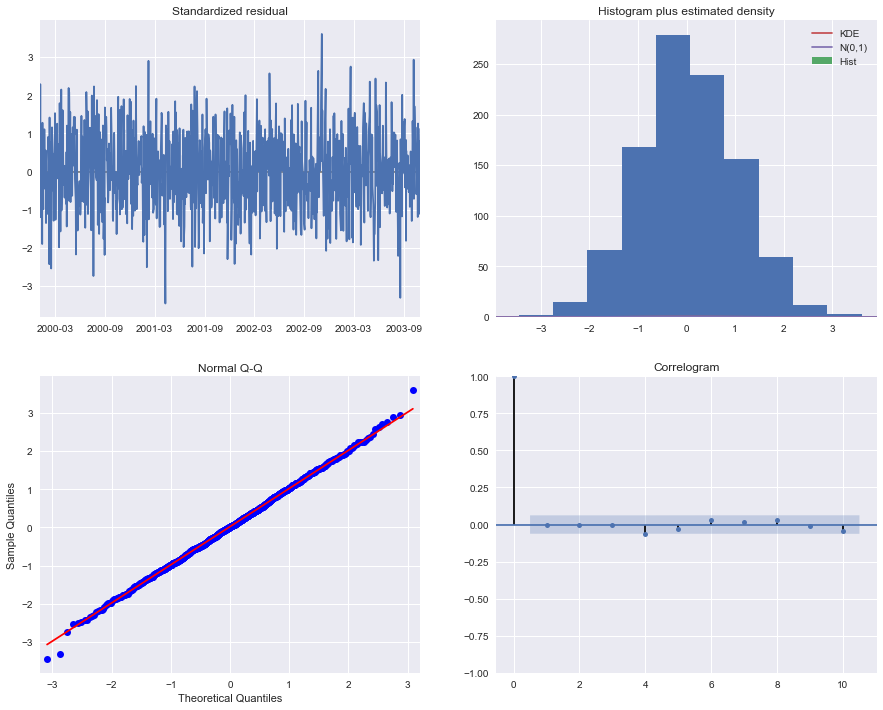

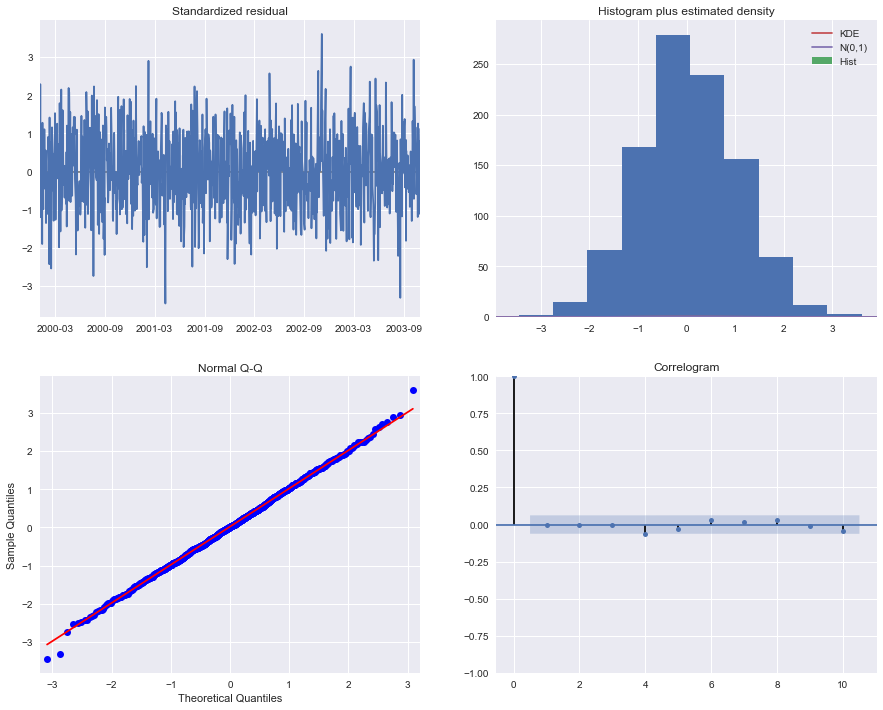

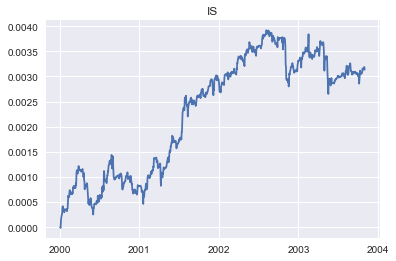

IR 0.7997694161245092


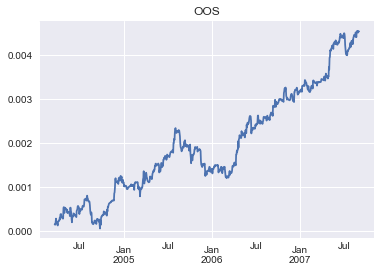

IR 1.3569683408780675


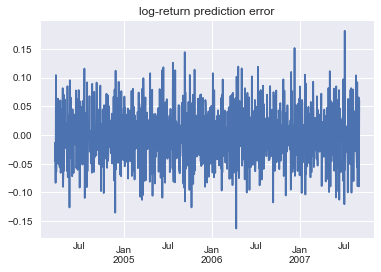

(3, 1, 2)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 1, 2)   Log Likelihood                1928.672
Date:                Sun, 01 Dec 2019   AIC                          -3845.344
Time:                        22:32:47   BIC                          -3815.904
Sample:                    01-03-2000   HQIC                         -3834.154
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4539      4.170      0.109      0.913      -7.720       8.628
ar.L2          0.1234      2.509      0.049      0.961      -4.794       5.041
ar.L3          0.0058      0.114      0.05

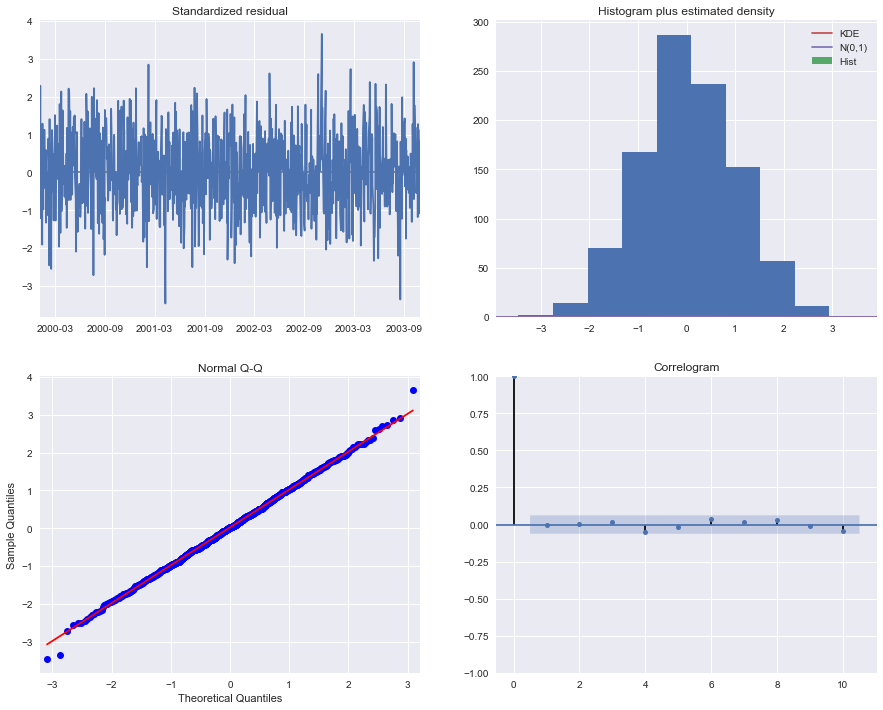

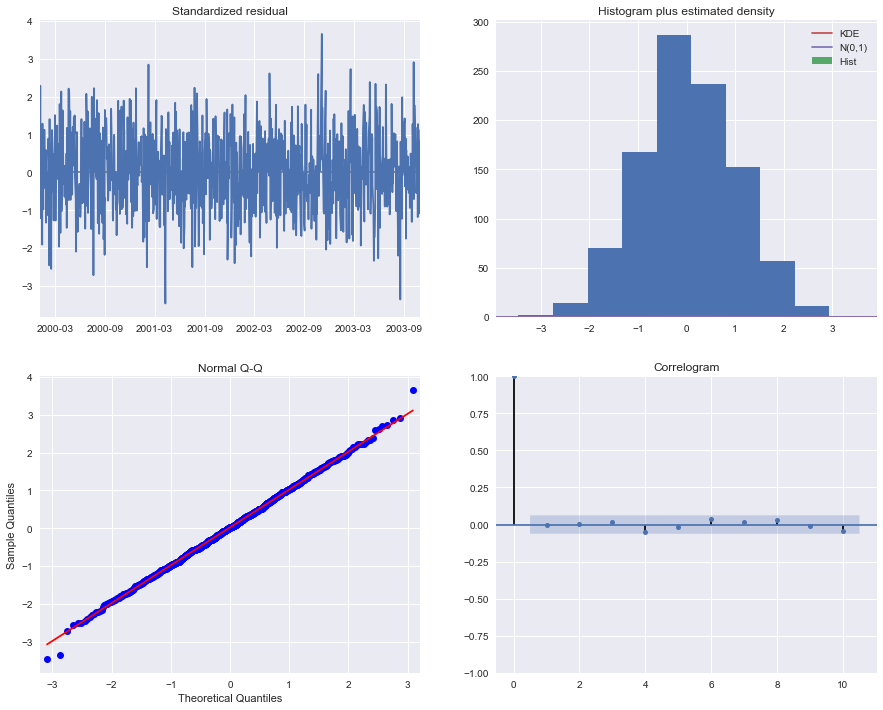

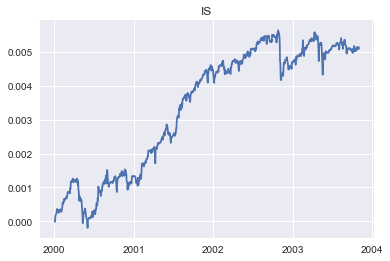

IR 0.9993129115603752


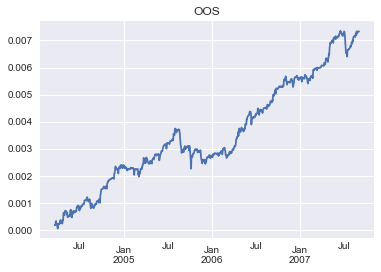

IR 1.8615073364844248


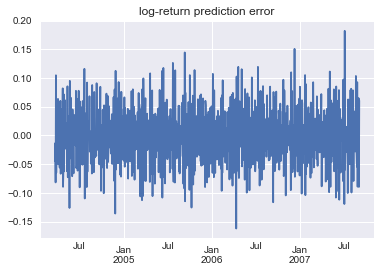

(3, 1, 3)


/Users/jan/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 1, 3)   Log Likelihood                1931.803
Date:                Sun, 01 Dec 2019   AIC                          -3849.605
Time:                        22:32:50   BIC                          -3815.258
Sample:                    01-03-2000   HQIC                         -3836.550
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1406      0.922     -0.153      0.879      -1.947       1.666
ar.L2          0.5667      0.376      1.507      0.132      -0.170       1.304
ar.L3          0.3924      0.738      0.532      0.5

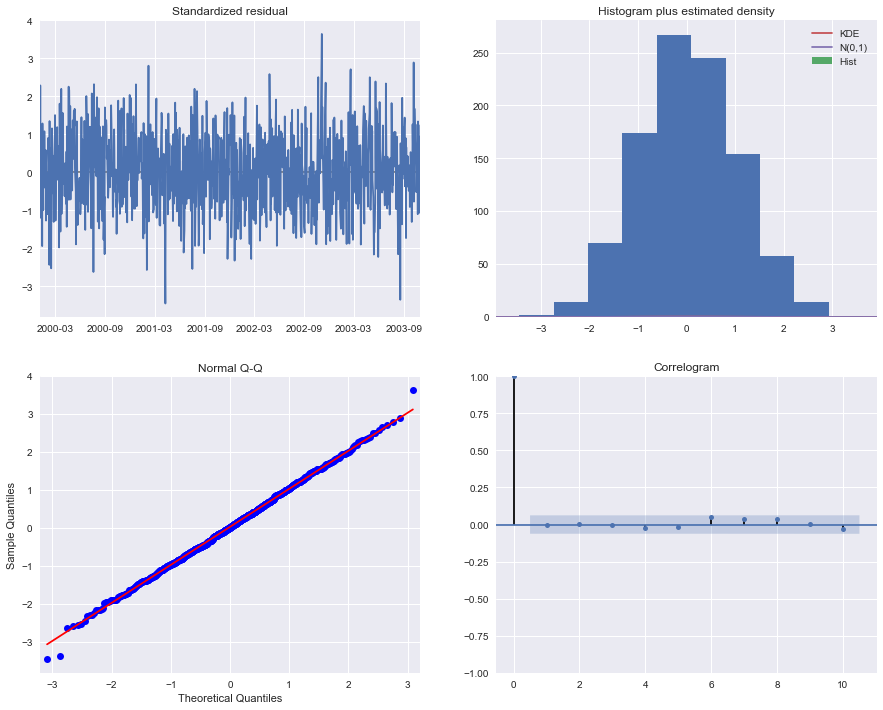

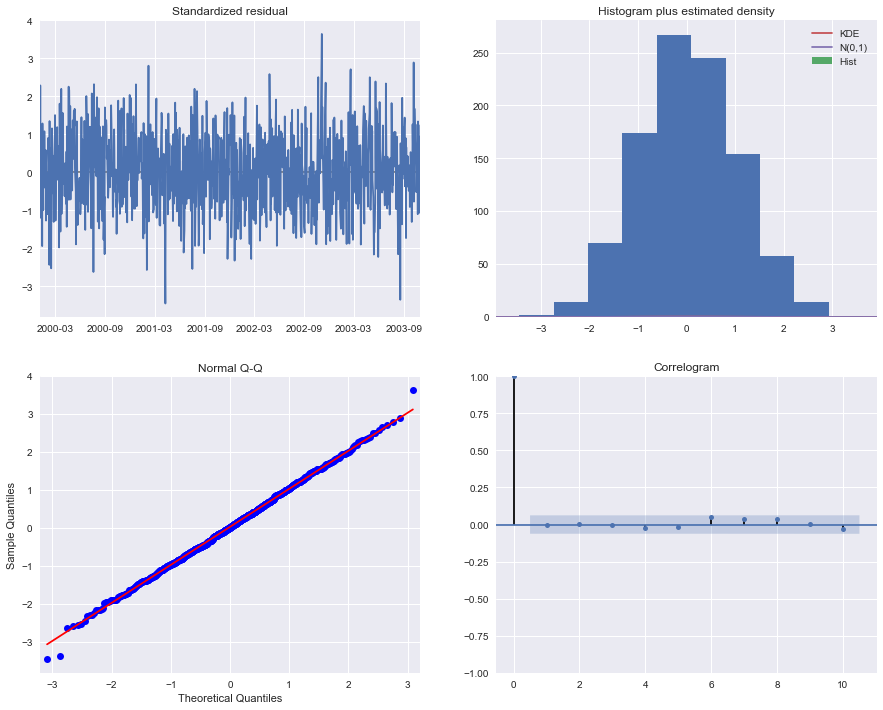

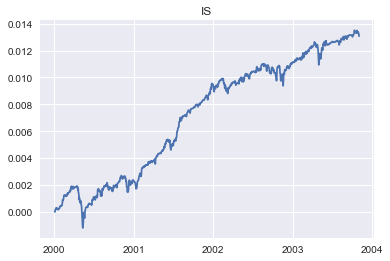

IR 1.6171757225406997


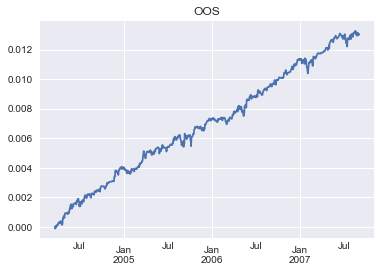

IR 2.11324856741064


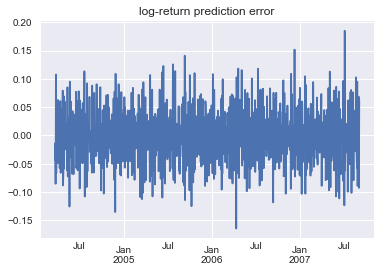

(3, 1, 4)


/Users/jan/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 1, 4)   Log Likelihood                1931.105
Date:                Sun, 01 Dec 2019   AIC                          -3846.210
Time:                        22:32:53   BIC                          -3806.956
Sample:                    01-03-2000   HQIC                         -3831.290
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5811      0.471      1.235      0.217      -0.341       1.503
ar.L2         -0.3751      0.570     -0.658      0.510      -1.492       0.742
ar.L3         -0.1583      0.426     -0.371      0.7

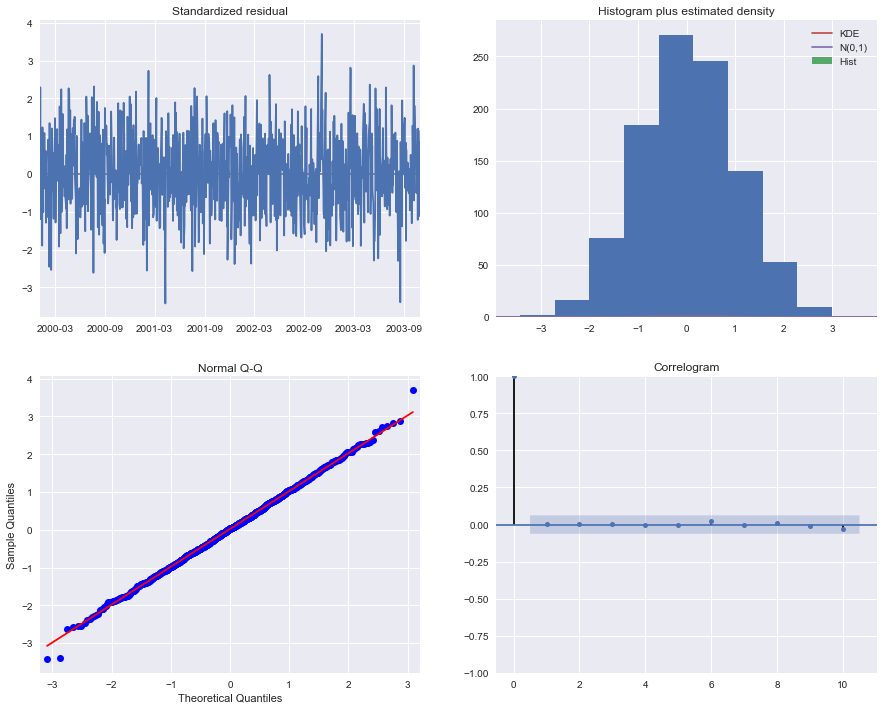

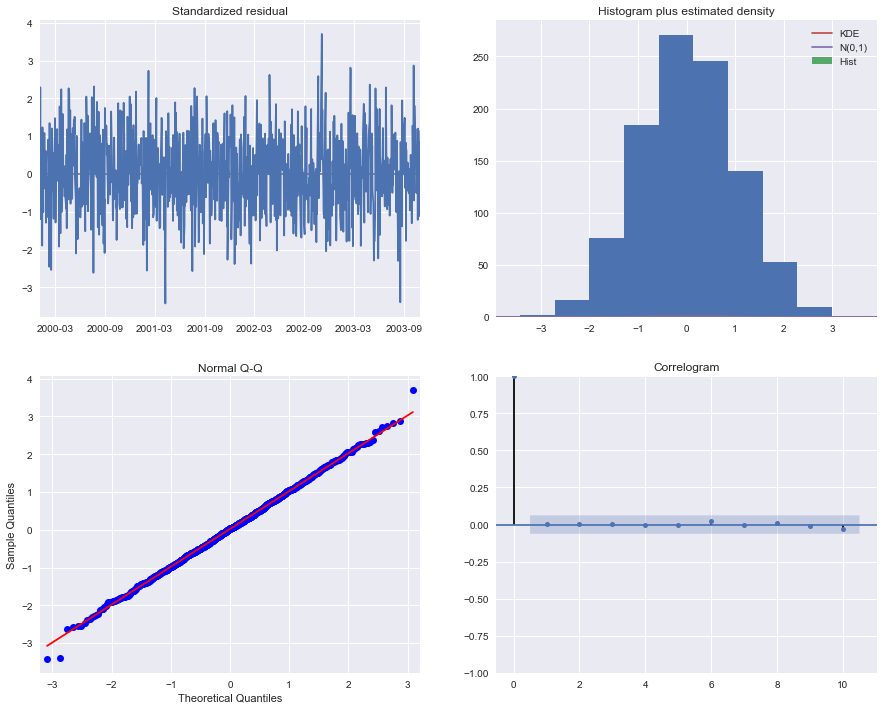

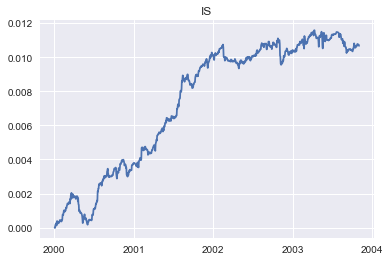

IR 1.4788966490627877


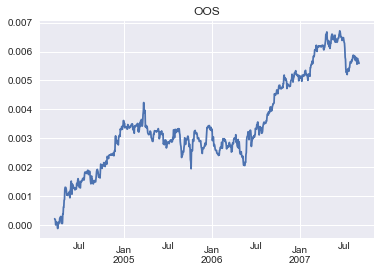

IR 0.941271867540029


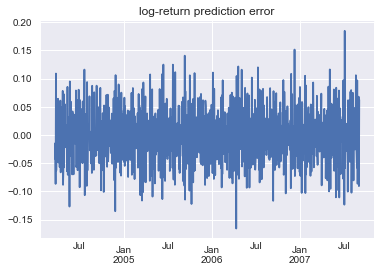

(4, 1, 1)


/Users/jan/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(4, 1, 1)   Log Likelihood                1930.301
Date:                Sun, 01 Dec 2019   AIC                          -3848.602
Time:                        22:32:56   BIC                          -3819.162
Sample:                    01-03-2000   HQIC                         -3837.412
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1839      0.416      0.442      0.659      -0.632       1.000
ar.L2         -0.0364      0.034     -1.065      0.287      -0.103       0.031
ar.L3          0.0061      0.039      0.158      0.8

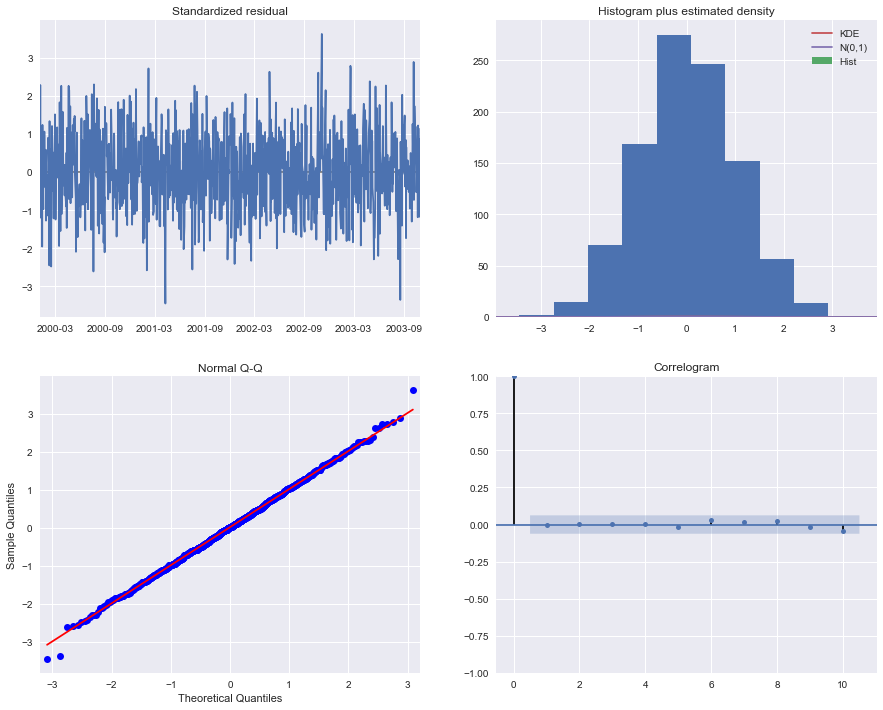

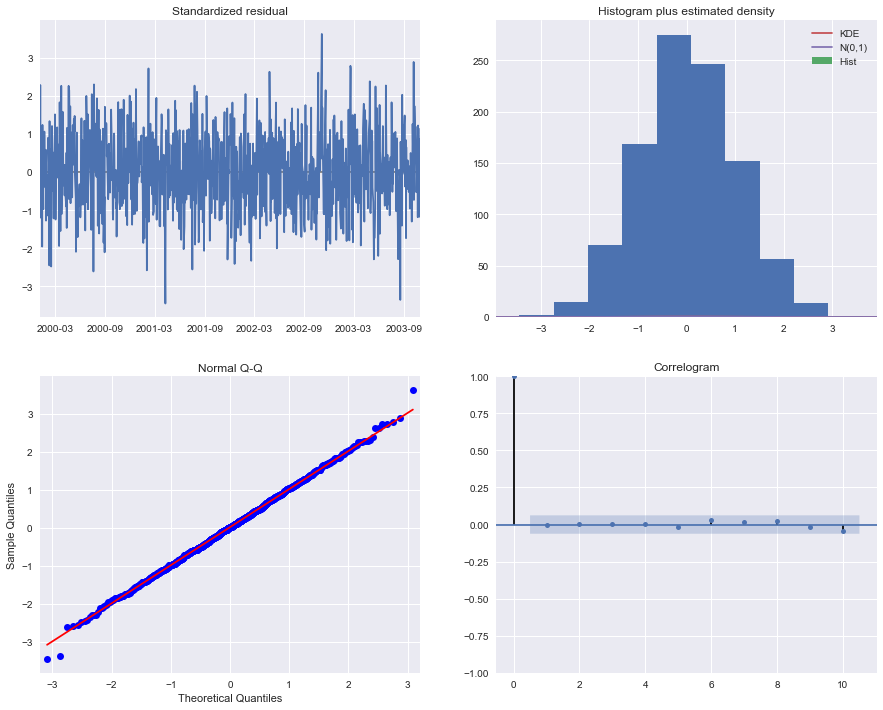

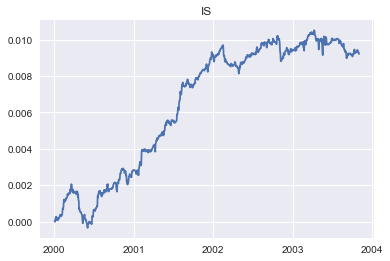

IR 1.3396772513469706


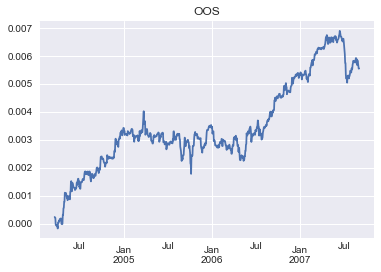

IR 0.955201392951989


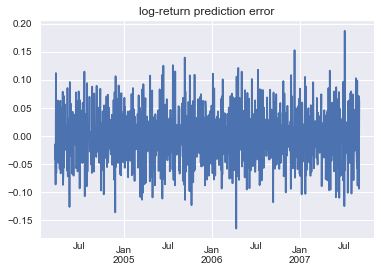

(4, 1, 2)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(4, 1, 2)   Log Likelihood                1931.145
Date:                Sun, 01 Dec 2019   AIC                          -3848.290
Time:                        22:32:59   BIC                          -3813.943
Sample:                    01-03-2000   HQIC                         -3835.235
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4468      0.348      1.285      0.199      -0.235       1.129
ar.L2         -0.4256      0.334     -1.275      0.202      -1.080       0.229
ar.L3          0.0037      0.037      0.10

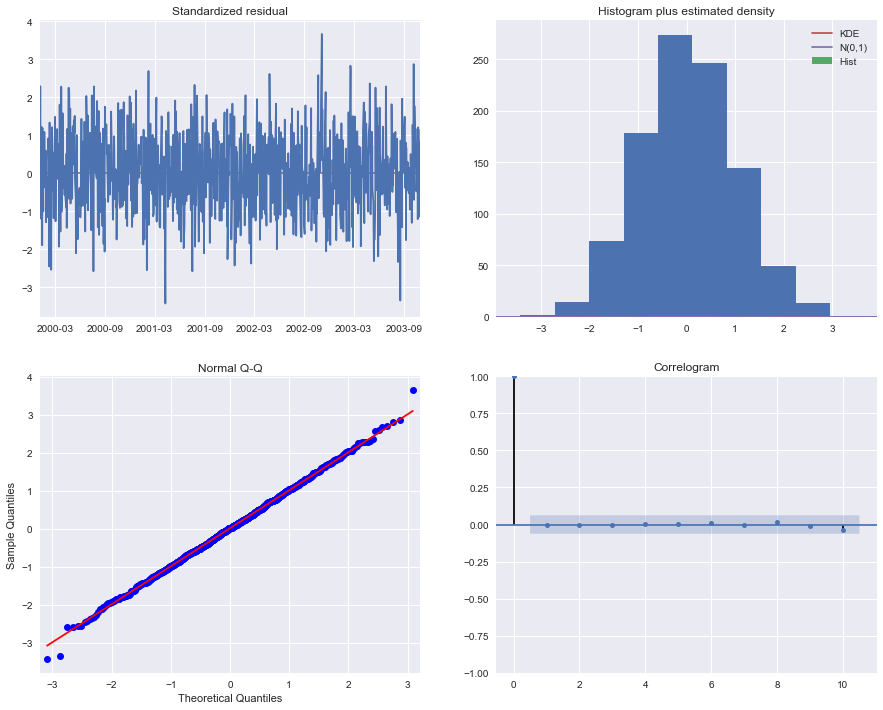

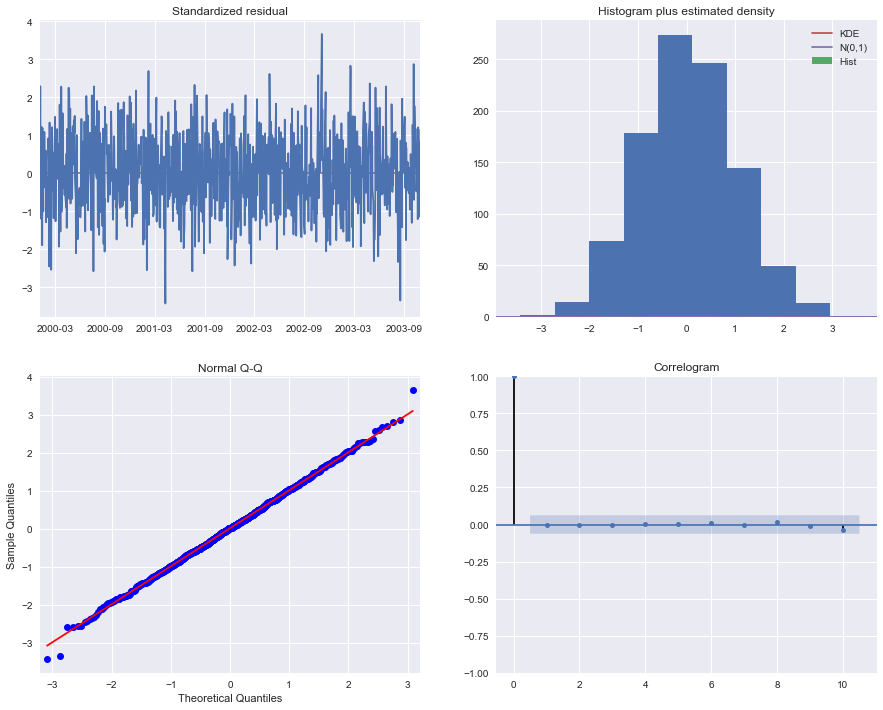

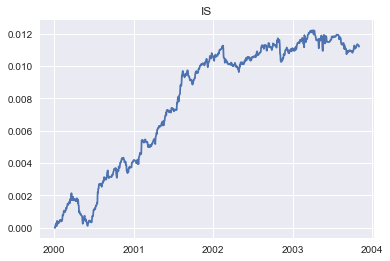

IR 1.4876372635315913


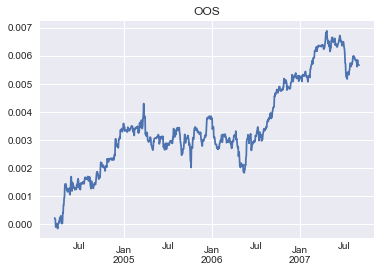

IR 0.8821271436986629


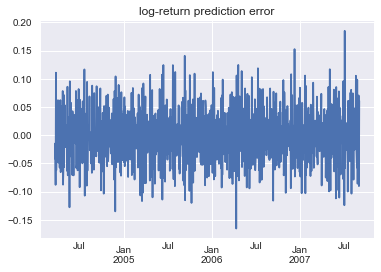

(4, 1, 3)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(4, 1, 3)   Log Likelihood                1931.081
Date:                Sun, 01 Dec 2019   AIC                          -3846.161
Time:                        22:33:01   BIC                          -3806.907
Sample:                    01-03-2000   HQIC                         -3831.241
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2740      0.369      0.744      0.457      -0.448       0.996
ar.L2         -0.2671      0.407     -0.657      0.511      -1.065       0.530
ar.L3         -0.1739      0.355     -0.49

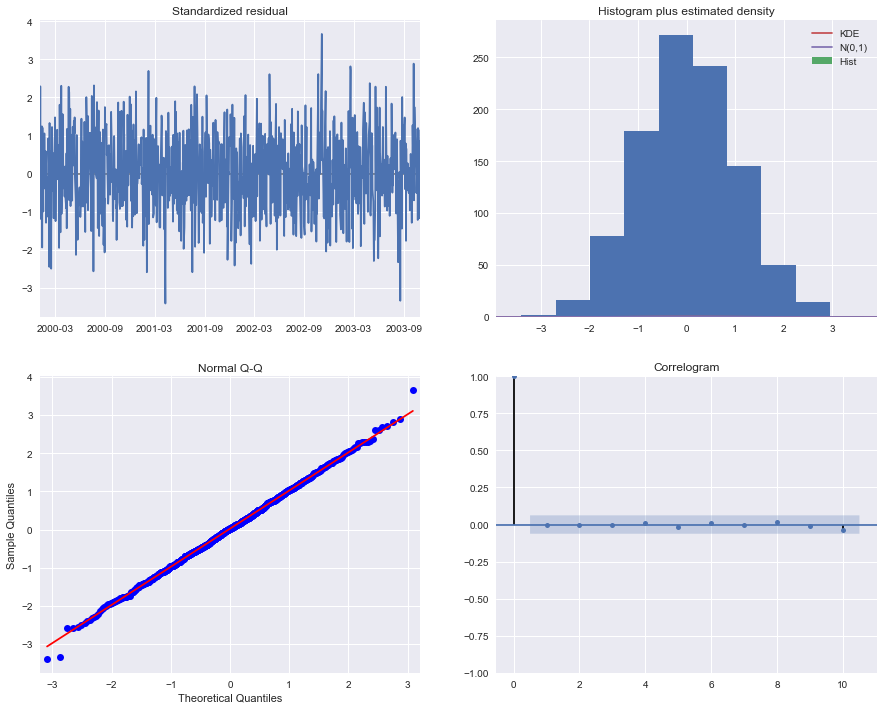

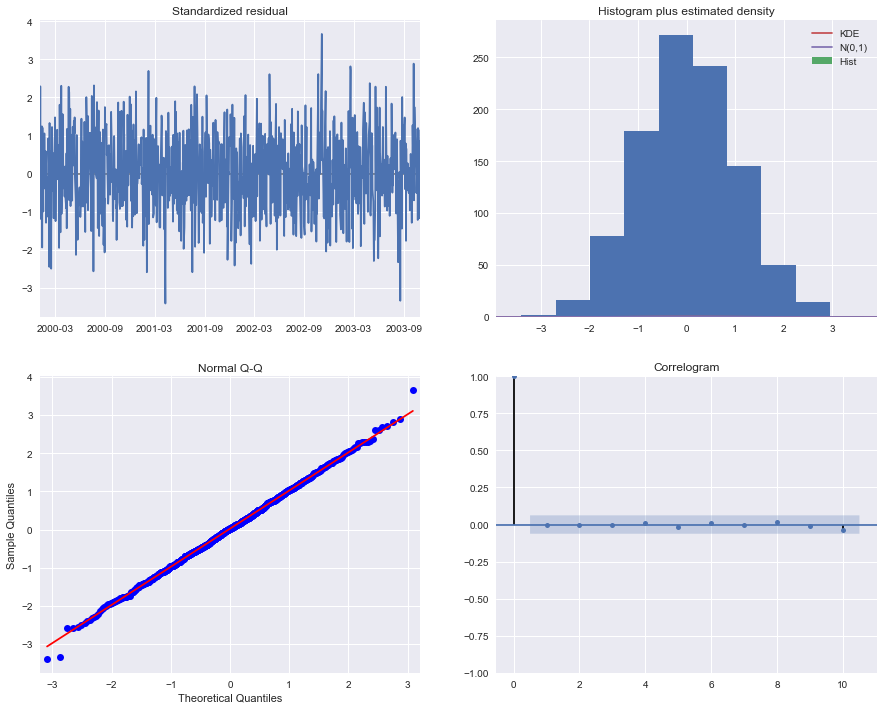

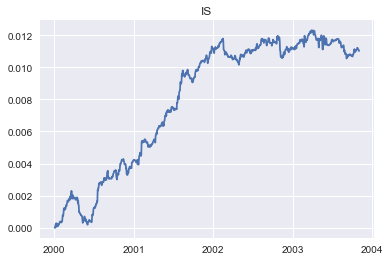

IR 1.483772512964708


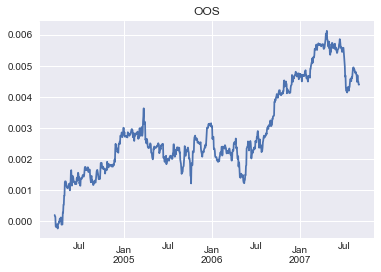

IR 0.6790379973526938


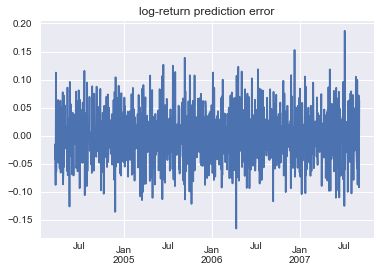

(4, 1, 4)
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(4, 1, 4)   Log Likelihood                1932.124
Date:                Sun, 01 Dec 2019   AIC                          -3846.249
Time:                        22:33:04   BIC                          -3802.088
Sample:                    01-03-2000   HQIC                         -3829.464
                         - 10-31-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3734      0.303      1.233      0.218      -0.220       0.967
ar.L2         -0.4413      0.354     -1.247      0.212      -1.135       0.252
ar.L3         -0.1163      0.362     -0.32

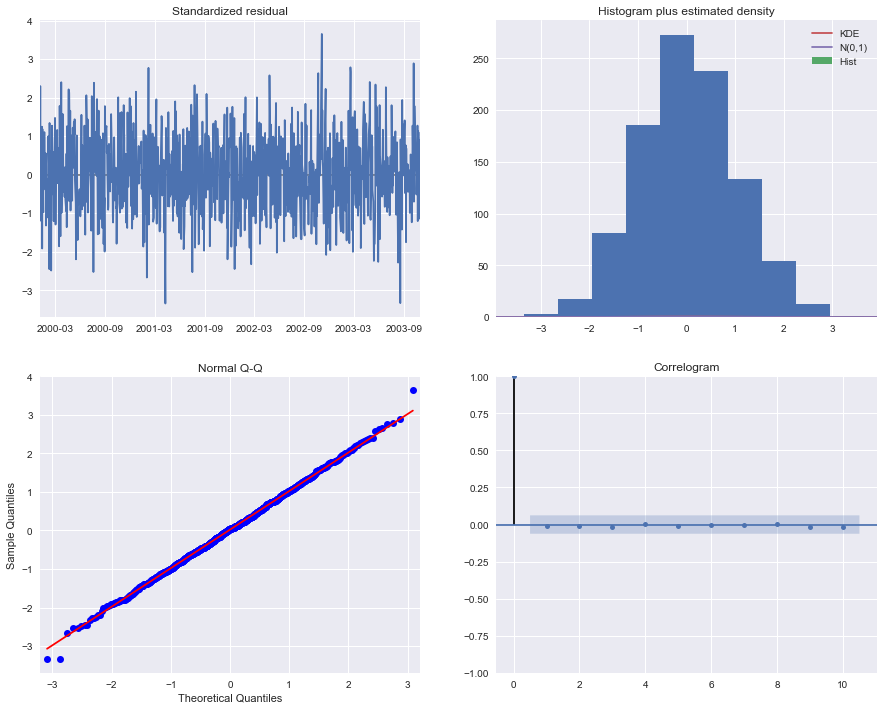

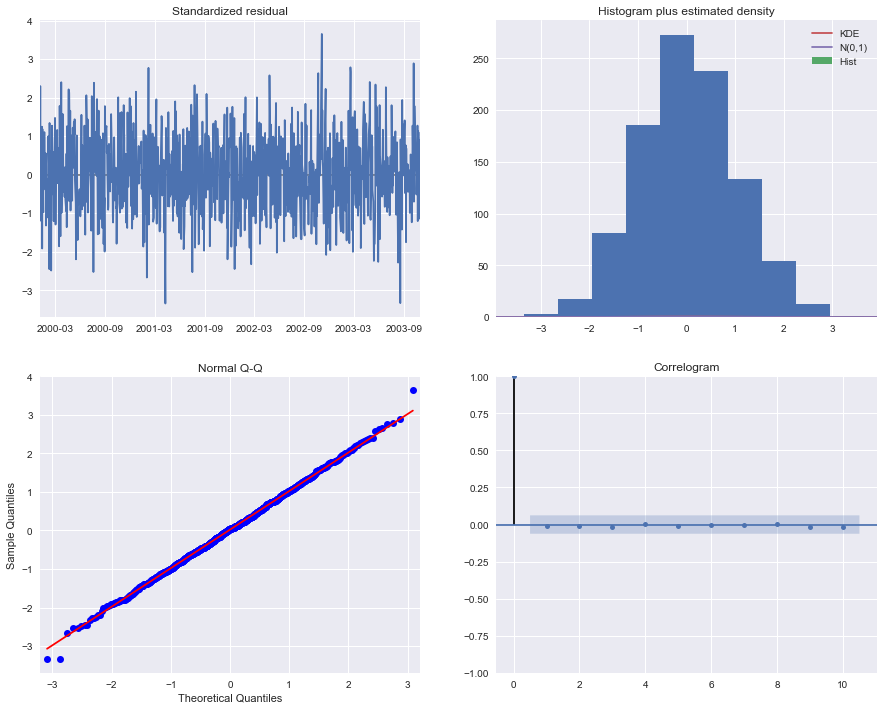

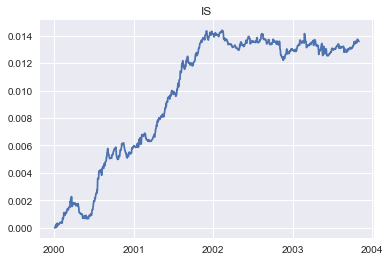

IR 1.6894362124919031


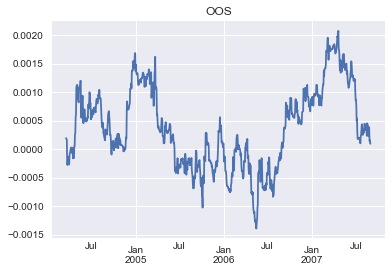

IR 0.01392218348024091


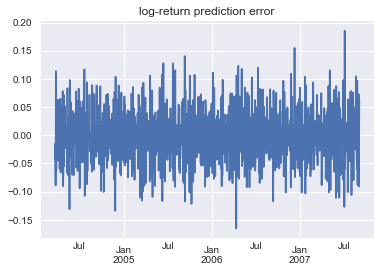

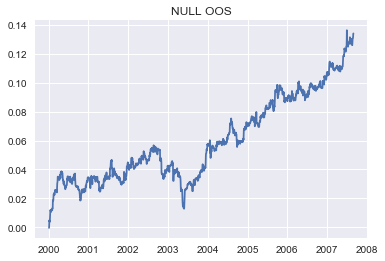

IR 0.8527777647530586


p  d  q        is       oos       is_aic       is_bic  \
0   1  1  1  1.494213  2.447181 -3856.131645 -3841.411381   
1   1  1  2  1.499895  2.468582 -3854.150876 -3834.523857   
5   2  1  2  1.513784  2.267398 -3852.482512 -3827.948738   
6   2  1  3  1.550203  2.324605 -3850.738930 -3821.298401   
10  3  1  3  1.617176  2.113249 -3849.605014 -3815.257730   
12  4  1  1  1.339677  0.955201 -3848.602125 -3819.161597   
13  4  1  2  1.487637  0.882127 -3848.289901 -3813.942618   
3   1  1  4  1.298735  1.067521 -3848.174040 -3818.733511   
7   2  1  4  1.450554  0.921543 -3847.826896 -3813.479613   
4   2  1  1  0.799726  1.357044 -3847.800064 -3828.173045   
2   1  1  3  0.873434  1.640122 -3846.333608 -3821.799834   
15  4  1  4  1.689436  0.013922 -3846.248771 -3802.087978   
11  3  1  4  1.478897  0.941272 -3846.209852 -3806.955814   
14  4  1  3  1.483773  0.679038 -3846.161498 -3806.907459   
8   3  1  1  0.799769  1.356968 -3845.800310 -3821.266536   
9   3  1  2  0.999313  1.861507 -3845.344294 -3815.903765   

                                               params  
0   ar.L1     0.925581
ma.L1    -0.961756
sigma2  ...  
1   ar.L1     0.927170
ma.L1    -0.967368
ma.L2   ...  
5   ar.L1     0.139060
ar.L2     0.724509
ma.L1   ...  
6   ar.L1     0.076736
ar.L2     0.791080
ma.L1   ...  
10  ar.L1    -0.140602
ar.L2     0.566740
ar.L3   ...  
12  ar.L1     0.183921
ar.L2    -0.036362
ar.L3   ...  
13  ar.L1     0.446818
ar.L2    -0.425557
ar.L3   ...  
3   ar.L1     0.245017
ma.L1    -0.279379
ma.L2   ...  
7   ar.L1     0.370727
ar.L2    -0.481034
ma.L1   ...  
4   ar.L1    -0.019561
ar.L2    -0.038753
ma.L1   ...  
2   ar.L1     0.208210
ma.L1    -0.241883
ma.L2   ...  
15  ar.L1     0.373407
ar.L2    -0.441311
ar.L3   ...  
11  ar.L1     0.581097
ar.L2    -0.375129
ar.L3   ...  
14  ar.L1     0.274034
ar.L2    -0.267149
ar.L3   ...  
8   ar.L1    -0.015193
ar.L2    -0.038608
ar.L3   ...  
9   ar.L1     0.453851
ar.L2     0.123445
ar.L3   ...

In [8]:

x = Y

train_pct = 0.5
train = int(train_pct*x.shape[0])

# introduce NaNs to observe behavior
# x.loc[np.random.randint(1,len(x[:train]), len(x[:train]))] = np.nan
# x.loc[np.random.randint(len(x[:train])+1, len(x), len(x[train:]))] = np.nan

p_list = []
q_list = []
d_list = []
is_list = []
oos_list = []
is_aic_list = []
is_bic_list = []
params_list = []
for p in range(1, 5):
    for q in range(1, 5):
        for d in (1,):
            if q==p==0:
                continue
                
            p_list.append(p)
            q_list.append(q)
            d_list.append(d)
            
            order=(p, d, q)
            print(order)
            # IS fit
            mod = sm.tsa.statespace.SARIMAX(x[:train],
                                            order=order,
            #                                 seasonal_order=(0, 0, 0, 0),
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False
                                           )

            fit_results = mod.fit()
            print(fit_results.summary())
            params_list.append(fit_results.params)
            fit_results.plot_diagnostics(figsize=(15, 12))
            plt.show()

            # IS prediction 
            pred = fit_results.get_prediction(dynamic=False)
            
            trad_ret = (pred.predicted_mean-x.shift(1))*x.diff()
            trad_ret.cumsum().plot()
            plt.title('IS')
            plt.show()
            ir = trad_ret.mean()/(trad_ret.std()/np.sqrt(250))
            is_list.append(ir)
            is_bic_list.append(fit_results.bic)
            is_aic_list.append(fit_results.aic)
            print('IR',ir)

            # OOS prediction
            mod = sm.tsa.statespace.SARIMAX(x[train:],
                                            order=order,
            #                                 seasonal_order=(0, 0, 0, 0),
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False
                                           )

            oos_results = mod.filter(fit_results.params)# this is needed to ingest data but doesn't change my test data 
            pred = oos_results.get_prediction(dynamic=False,start=100)
            pred_ci = pred.conf_int()


            trad_ret = (pred.predicted_mean-x.shift(1))*x.diff()
            trad_ret.cumsum().plot()
            plt.title('OOS')
            plt.show()
            ir = trad_ret.mean()/(trad_ret.std()/np.sqrt(250))
            oos_list.append(ir)
            print('IR',ir)
            
            (pred.predicted_mean.diff()-x.diff()).plot()
            plt.title('log-return prediction error')
            plt.show()
            
# Null model: predict next returns as opposite signed last return
trad_ret = (-x.diff().shift(1))*x.diff()
trad_ret.cumsum().plot()
plt.title('NULL OOS')
plt.show()
ir = trad_ret.mean()/(trad_ret.std()/np.sqrt(250))
print('IR',ir)


df = pd.DataFrame({'p':p_list, 'd':d_list, 'q':q_list,
                   'is':is_list, 'oos': oos_list, 'is_aic': is_aic_list,
                   'is_bic': is_bic_list, 'params':params_list
                  })
df_sorted = df.sort_values(by='is_aic')
df_sorted

# Adaptive Out-of-sample Forecasting

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1931.066
Date:                Sun, 01 Dec 2019   AIC                          -3856.132
Time:                        22:33:28   BIC                          -3841.411
Sample:                             0   HQIC                         -3850.537
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9256      0.034     27.339      0.000       0.859       0.992
ma.L1         -0.9618      0.025    -38.187      0.000      -1.011      -0.912
sigma2         0.0012   5.48e-05     22.354      0.0

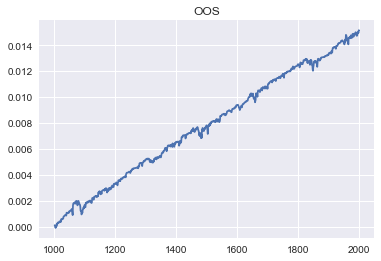

OOS ir 2.4028437327123124


In [9]:

x = Y
x.index = range(len(x))

train_pct = 0.5
train = int(train_pct*x.shape[0])
ACTION_LAG = 0
N_PERIODS = 1
order = (1,1,1)
ADAPTIVE = False

#######################################################################################
#########################################TRAIN#########################################
#######################################################################################

modl = sm.tsa.statespace.SARIMAX(x[:train], order=order)
modl_fit = modl.fit() 
print(modl_fit.summary())
    
    
#######################################################################################
#########################################TEST#########################################
#######################################################################################
x_test = x[train:]    
x_train = x[:train]
pred = None
for update_index in tqdm_notebook(range(0, len(x_test)-1)):

    next_x = x_test.iloc[update_index: update_index+1]
    x_train = x_train.append(next_x)
    modl = sm.tsa.statespace.SARIMAX(x_train, order=order)
    
    if ADAPTIVE:
        # this trains modl further each time a new data point arrives using prior parameters as 
        # starting values
        # TODO how to initilize properly, choose 'learning rate'?
        modl_fit = modl.fit(start_params=modl_fit.params , maxiter=5) 
    else:
        # this filters the series without training further
        modl_fit = modl.filter(modl_fit.params) 

    _pred_multi = modl_fit.forecast(N_PERIODS)
    
    # select the forecast furthest out in the future and put it in prediction series at
    # the timestamp of the next period
    _pred = pd.Series(data=_pred_multi.iloc[-1],
                     index=[x_test.index[update_index+1]])
    if pred is None:
        pred = _pred
    else:
        pred = pred.append(_pred)
    
trad_ret = (pred-x.shift(1))*x.diff().shift(-ACTION_LAG)
trad_ret.cumsum().plot()
plt.title('OOS')
plt.show()
ir = trad_ret.mean()/(trad_ret.std()/np.sqrt(250))
print('OOS ir', ir)



# Pitfalls of Irregularly Observed Multivariate Time Series
Regardless of the order that will eventually be used, we have to think carefully about which prices are observable and on which prices we can act. A bar is composed of several ticks observed at increasing time stamps. The last tick within the bar is observable (at the very least) at the closing time of the bar. We cannot assume a fill at this price in backtesting though. This fact is especially important when considering multiple instruments since the last tick of a bar may appear at different times for different instruments. If one were assuming fills at the close price, one would incur look-ahead bias or one would magically go back in time and trade at a past price. It is helpful to visualize these prices by a timeline as is done in Figure 1.

![title](tl.png)
At $t=0$ we observe the closing price of the zeroth bar $A_0$ which is the traded price $p_0^A$ some point in time before -- or directly at -- $t_0$. The same holds for $H_0$, where the last traded price $p_0^H$ occurred slightly after $p_0^A$. $Y_0$ can be computed from $A_0$ and $H_0$ and predictions for $Y_1$ and beyond based on it. There is some lag due to data transmission and computation time. So, the first price we may assume a fill at -- before slippage -- is $p_1^A$ and $p_1^H$. Alternatively, if one only has the bar data without the ticks, one may use $A_1$ and $H_1$ assuming that the close prices occurred not within the computation lag. Then, a one-step forecast doesn't make sense anymore. In any case, do *not* forward (or backward) fill prices. This is also a problem for estimation. If prices are forward filled, parameters will be biased in favor of mean-reversion. If there is no traded price for the asset and the hedge at (almost) the same time, record a NaN and don't forward fill. In the state space form, ARIMA can handle the NaNs and no imputation is necessary. Since, there will always be some discrepancy between traded prices of the asset and its hedge, a small bias is unavoidable without having continuous bid/ask quotes. If the holding period is sufficiently long, the hope is that this bias is negligible. 


## Proof by Simulation that ffill() Price Intoduces Bias

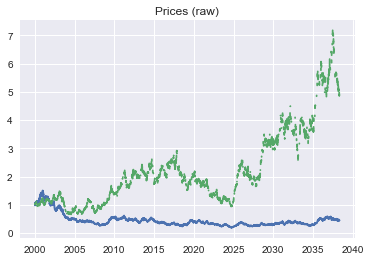

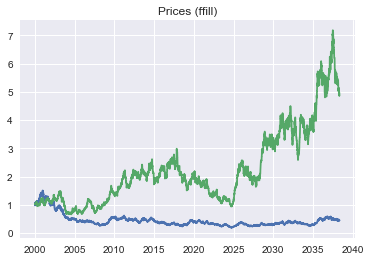

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:               SARIMAX(1, 1, 1)   Log Likelihood               13085.578
Date:                Sun, 01 Dec 2019   AIC                         -26165.156
Time:                        22:34:00   BIC                         -26145.605
Sample:                    01-03-2000   HQIC                        -26158.303
                         - 03-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4598      0.116      3.950      0.000       0.232       0.688
ma.L1         -0.5438      0.110     -4.931      0.000      -0.760      -0.328
sigma2         0.0003   4.21e-06     74.037      0.0

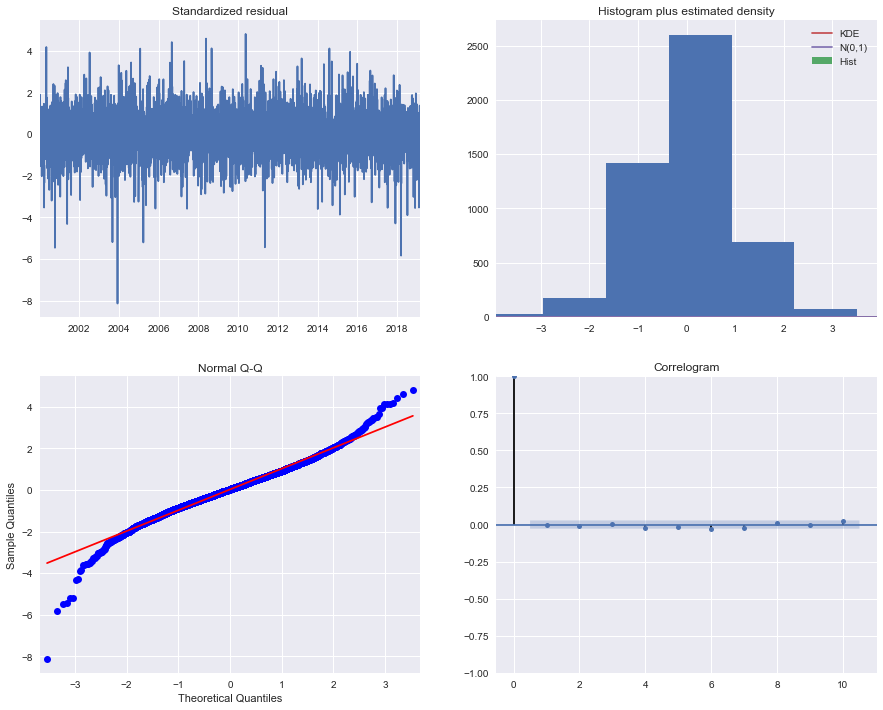

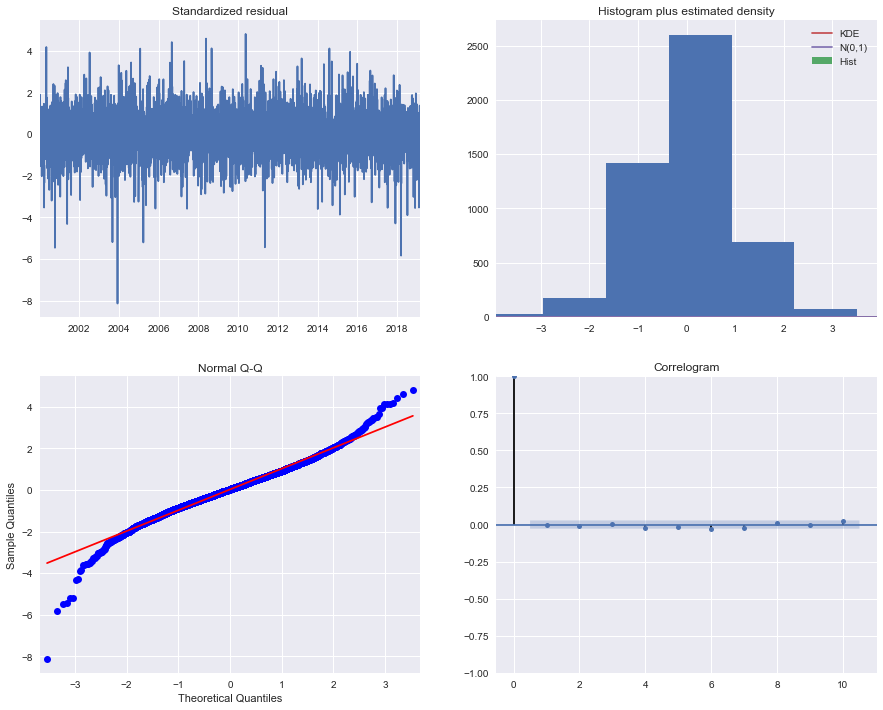

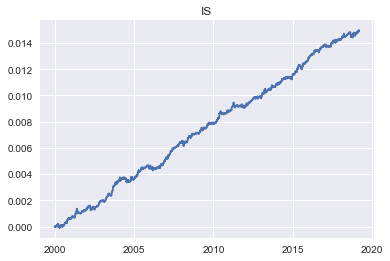

IR 1.589576204127624


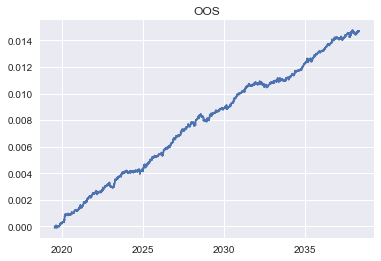

IR 1.6079886381218529


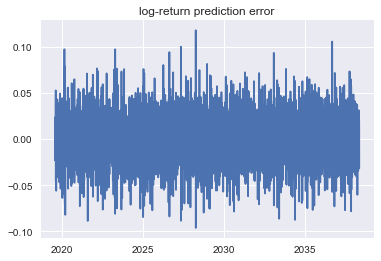

In [10]:
n_obs = 10000

# Common Gaussain returns
epsilon = np.random.normal(0.0,0.01, n_obs)

# Gaussian specific innovations
omega = np.random.normal(0, 0.01, epsilon.shape[0]) 
omega_H = np.random.normal(0, 0.01, epsilon.shape[0]) 
S = omega.cumsum()
S_H = omega_H.cumsum()


# Mean reverting process
#################################################
# Setting the mean reversion speed to zero implies
# a random walk and thus profits shouldn't be possible
R = ornstein_uhlenbeck(0.0, 0.0, epsilon.shape[0]+1, mu=0, x0=0)
R_H = ornstein_uhlenbeck(0.0, 0.0, epsilon.shape[0]+1, mu=0, x0=0)
#################################################

H = np.exp(np.cumsum(epsilon + omega_H + np.diff(R_H)))
A = np.exp(np.cumsum(epsilon + omega + np.diff(R)))

na_prices = pd.DataFrame(data={'H':H, 'A':A})
na_prices.loc[np.random.randint(1,len(na_prices), int(0.9*len(na_prices))), 'A'] = np.nan


na_prices.index = pd.date_range(start='1/1/2000', periods=len(na_prices), freq='B')
plt.plot(na_prices)
plt.title('Prices (raw)')
plt.show()

#############CULPRIT#############################
#################################################
na_prices.ffill(inplace=True)
plt.plot(na_prices)
plt.title('Prices (ffill)')
plt.show()
#################################################
#################################################


Y = np.log(na_prices.A) - np.log(na_prices.A.iloc[0]) - (np.log(na_prices.H) - np.log(na_prices.H.iloc[0]))

x = Y
train_pct = 0.5
train = int(train_pct*x.shape[0])
order = (1, 1, 1)



# IS fit
mod = sm.tsa.statespace.SARIMAX(x[:train], order=order)

fit_results = mod.fit()
print(fit_results.summary())
fit_results.plot_diagnostics(figsize=(15, 12))
plt.show()

# IS prediction 
pred = fit_results.get_prediction(dynamic=False)

trad_ret = (pred.predicted_mean-x.shift(1))*x.diff()
trad_ret.cumsum().plot()
plt.title('IS')
plt.show()
ir = trad_ret.mean()/(trad_ret.std()/np.sqrt(250))
print('IR',ir)

# OOS prediction
mod = sm.tsa.statespace.SARIMAX(x[train:], order=order)

oos_results = mod.filter(fit_results.params)# this is needed to ingest data but doesn't change my test data 
pred = oos_results.get_prediction(dynamic=False,start=100)
pred_ci = pred.conf_int()


trad_ret = (pred.predicted_mean-x.shift(1))*x.diff()
trad_ret.cumsum().plot()
plt.title('OOS')
plt.show()
ir = trad_ret.mean()/(trad_ret.std()/np.sqrt(250))
print('IR',ir)

(pred.predicted_mean.diff()-x.diff()).plot()
plt.title('log-return prediction error')
plt.show()
            


The positve profits, where no profits should be possible, show that the ffill introduced a bias.

# Parametric Test of Local Mean Reversion

The autocorrelation function (ACF) of an ARMA(1,1) process is given by
$$\rho(\tau)=\frac{\gamma(\tau)}{\gamma(0)}=\phi^{\tau-1} \frac{(\phi+\theta)(1+\phi \theta)}{1+2 \theta \phi+\theta^{2}}, \quad \tau \geq 1.$$

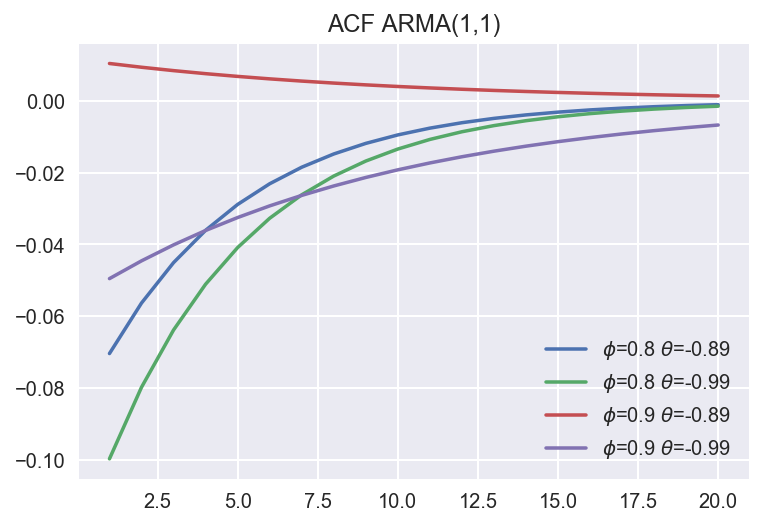

$\phi$=0.8 $\theta$=-0.89  $\phi$=0.8 $\theta$=-0.99  \
1                   -0.070416                  -0.099773   
2                   -0.056333                  -0.079818   
3                   -0.045066                  -0.063855   
4                   -0.036053                  -0.051084   
5                   -0.028842                  -0.040867   
6                   -0.023074                  -0.032694   
7                   -0.018459                  -0.026155   
8                   -0.014767                  -0.020924   
9                   -0.011814                  -0.016739   
10                  -0.009451                  -0.013391   
11                  -0.007561                  -0.010713   
12                  -0.006049                  -0.008570   
13                  -0.004839                  -0.006856   
14                  -0.003871                  -0.005485   
15                  -0.003097                  -0.004388   
16                  -0.002478                  -0.003510   
17                  -0.001982                  -0.002808   
18                  -0.001586                  -0.002247   
19                  -0.001268                  -0.001797   
20                  -0.001015                  -0.001438   

    $\phi$=0.9 $\theta$=-0.89  $\phi$=0.9 $\theta$=-0.99  
1                    0.010468                  -0.049520  
2                    0.009421                  -0.044568  
3                    0.008479                  -0.040112  
4                    0.007631                  -0.036100  
5                    0.006868                  -0.032490  
6                    0.006181                  -0.029241  
7                    0.005563                  -0.026317  
8                    0.005007                  -0.023685  
9                    0.004506                  -0.021317  
10                   0.004056                  -0.019185  
11                   0.003650                  -0.017267  
12                   0.003285                  -0.015540  
13                   0.002957                  -0.013986  
14                   0.002661                  -0.012587  
15                   0.002395                  -0.011329  
16                   0.002155                  -0.010196  
17                   0.001940                  -0.009176  
18                   0.001746                  -0.008259  
19                   0.001571                  -0.007433  
20                   0.001414                  -0.006689

In [22]:
def arma11_acf(tau, phi, theta):
    return phi**(tau-1)*((phi+theta)*(1+phi*theta)/(1+2*theta*phi+theta**2))

df = pd.DataFrame(index=range(1,21))
for phi in (0.8,0.9):
    for theta in (-0.89, -0.99):
        df[f'$\phi$={phi} ' +r'$\theta$=' +str(theta)] = df.index.to_series().apply(arma11_acf, args=(phi,theta))
df.plot()
plt.title('ACF ARMA(1,1)')
plt.show()
df

# Optimal Trading under Transaction costs 

The nice thing about the ARIMA model is that a multi-period forecasts are easy to obtain. Hence, one can compute the expected return from now until some point in the future and compare the maximum cumulative return to the expected transaction costs. The decision to enter a position can then be based on the sign and magnitude of the difference.

/Users/jan/anaconda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jan/anaconda/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


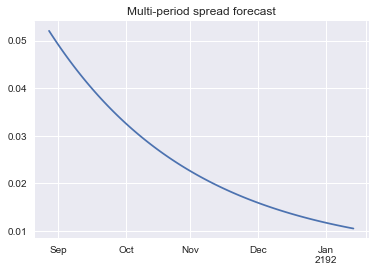

In [15]:
n_obs = 50000

# Common Gaussain returns
epsilon = np.random.normal(0.0,0.01, n_obs)

# Gaussian specific innovations
omega = np.random.normal(0, 0.001, epsilon.shape[0]) 
omega_H = np.random.normal(0, 0.001, epsilon.shape[0]) 
S = omega.cumsum()
S_H = omega_H.cumsum()

# Mean reverting process
R = ornstein_uhlenbeck(0.01, 0.01, epsilon.shape[0]+1, mu=0, x0=0)
R_H = ornstein_uhlenbeck(0.1, 0.01, epsilon.shape[0]+1, mu=0, x0=0)

H = np.exp(np.cumsum(epsilon + omega_H + np.diff(R_H)))
A = np.exp(np.cumsum(epsilon + omega + np.diff(R)))
prices = pd.DataFrame(data={'H':H, 'A':A})
prices.index = pd.date_range(start='1/1/2000', periods=len(prices), freq='B')
Y = np.log(prices.A) - np.log(prices.A.iloc[0]) - (np.log(prices.H) - np.log(prices.H.iloc[0]))

x = Y
order = (1, 1, 1)
mod = sm.tsa.statespace.SARIMAX(x, order=order)
modl_fit = mod.fit()
modl_fit.forecast(100).plot()
plt.title('Multi-period spread forecast')